# 1.0 Imports

In [20]:
import os
import warnings
import pandas as pd
import math
import numpy as np
import datetime
import inflection
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from tabulate import tabulate
from boruta import BorutaPy
from pathlib import Path

from IPython.core.display import HTML
from IPython.display import Image

from xgboost import XGBRegressor
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import RandomizedSearchCV, train_test_split, BaseCrossValidator
from skopt import BayesSearchCV, space 

## 0.1. Helper functions

In [21]:
# Define function to calculate cramer v 
def cramerv(x,y):
    cm = pd.crosstab(x,y).values
    n = cm.sum()
    r, k = cm.shape

    chi2 = stats.chi2_contingency(cm)[0]
    chis2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chis2corr/n) / min(kcorr-1, rcorr-1))

def mean_absolute_percentage_error(y, yhat):
    return  np.mean( np.abs( (y - yhat) / y ) )

def mean_percentage_error(y, yhat):
    return  np.mean((y - yhat) / y)


def ml_error (model_name: str, y: pd.Series, yhat: pd.Series) -> pd.DataFrame:
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_absolute_error(y, yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index=[0])    

def cross_val(model, kfold, x_training):
    mae_list = []
    mape_list = []
    rmse_list = []

    print(f'Model in Trainning: {model.__class__.__name__}')

    # Creating the cross validation folds
    for k in reversed(range(1, kfold+1)):
        print(f'Kfold: {k}')

        start_lim = x_training['date'].max() - datetime.timedelta(k*6*7)      # We decide early that the window to split the data in tranning and test will use units of 6 weeks. 
        end_lim = x_training['date'].max() - datetime.timedelta((k-1)*6*7)

        # Filtering dataframe
        trainning = x_training[x_training['date'] < start_lim]
        validation = x_training[(x_training['date'] >= start_lim) & (x_training['date'] <= end_lim)] 

        # Cross validation datasets (just removing the date and sales columns again, since this columns will not be used on tranning)
        xtrainning = trainning.drop(columns=['date', 'sales'], axis = 1)
        ytrainning = trainning['sales']

        xvalidation = validation.drop(columns=['date', 'sales'], axis = 1)
        yvalidation = validation['sales']

        # Model tranning 
        m = model.fit(xtrainning, ytrainning)
        yhat = m.predict(xvalidation)

        # Performance
        results = ml_error(model.__class__.__name__, np.expm1(yvalidation), np.expm1(yhat))
        mae_list.append(results['MAE'])
        mape_list.append(results['MAPE'])
        rmse_list.append(results['RMSE'])

    print('---------------------------------------------')

    return pd.DataFrame({'Model Name': model.__class__.__name__ ,
                         'MAE_CV': np.round(np.mean(mae_list), 2).astype(str) + '+/-' + np.round(np.std(mae_list), 2).astype(str),
                         'MAPE_CV': np.round(np.mean(mape_list), 2).astype(str) + '+/-' + np.round(np.std(mape_list), 2).astype(str),
                         'RMSE_CV': np.round(np.mean(rmse_list), 2).astype(str) + '+/-' + np.round(np.std(rmse_list), 2).astype(str),
                         }, index = [0])

class TimeSeriesWindowSplit(BaseCrossValidator):
    """
    CV temporal com janelas fixas retroativas (ex.: 6 semanas).
    Use .fit(X, y, groups=dates) — 'dates' é um vetor de datas (len == len(X) == len(y)).
    """
    def __init__(self, n_splits=5, window_weeks=6, drop_empty=True):
        self.n_splits = n_splits
        self.window_weeks = window_weeks
        self.drop_empty = drop_empty

    def get_n_splits(self, X=None, y=None, groups=None):
        return self.n_splits

    def split(self, X, y=None, groups=None):
        if groups is None:
            raise ValueError("Passe as datas via 'groups' em .fit(X, y, groups=dates).")

        # Converte para Series de datetime e cria índices POSICIONAIS 0..n-1
        dates = pd.to_datetime(pd.Series(groups)).reset_index(drop=True)
        n = len(dates)
        idx = np.arange(n)

        end_date = dates.max()
        window = datetime.timedelta(weeks=self.window_weeks)

        produced = 0
        # Gera n_splits janelas de trás pra frente (cada uma com 'window_weeks')
        for k in range(self.n_splits, 0, -1):
            start = end_date - k * window
            end   = end_date - (k - 1) * window

            mask_val   = (dates >= start) & (dates <= end)
            mask_train = (dates < start)

            train_idx = idx[mask_train.to_numpy()]
            val_idx   = idx[mask_val.to_numpy()]

            if (len(train_idx) == 0 or len(val_idx) == 0):
                print(f"⚠️ Split {k} descartado (train={len(train_idx)}, test={len(val_idx)})")
                if self.drop_empty:
                    continue
                else:
                    raise ValueError(
                        f"Fold vazio em k={k}: train={len(train_idx)}, val={len(val_idx)} "
                        f"(janela {start.date()}..{end.date()}). Ajuste n_splits/window."
                    )

            produced += 1
            yield train_idx, val_idx

        if produced == 0:
            raise ValueError("Nenhum fold válido foi produzido — reduza n_splits ou aumente window_weeks.")

# --- Classe wrapper para injetar early stopping ---
class XGBWithEarlyStopping(XGBRegressor):
    def fit(self, X, y, **kwargs):
        # Se o CV passar um "eval_set", usa; caso contrário, cria usando o último 20% dos dados
        if "eval_set" not in kwargs:
            n = int(0.8 * X.shape[0])
            X_train, X_val = X[:n], X[n:]
            y_train, y_val = y[:n], y[n:]
            kwargs["eval_set"] = [(X_val, y_val)]
        # sempre força early stopping
        kwargs["early_stopping_rounds"] = kwargs.get("early_stopping_rounds", 100)
        kwargs["verbose"] = False
        return super().fit(X, y, **kwargs)            

def jupyter_settings():
    %matplotlib inline
    # %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 16
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
# Histogram default params
histogram_args = {'stat': 'density',
                    'kde': True,
                    'kde_kws': dict(cut=3),
                    'bins': 50
                    }

### 0.1.1 Settings

In [22]:
jupyter_settings()

# Ignoring the Future Warnings of XGBoost so they dont get printed in the loop 
warnings.filterwarnings(
    "ignore",
    message=r".*Series\.base is deprecated.*",
    category=FutureWarning
)

## 0.2. Loading data

In [23]:
root = Path().resolve()
data_dir = root / 'data'

original_df_clean = pd.read_csv(data_dir / 'processed' /'originaldf_cleaned.csv', low_memory=False)   # original dataframe cleaned prior any transformations
df4 = pd.read_csv(data_dir / 'processed' /'df_cleaned.csv', low_memory=False)                         # dataframe clead after transformations

# 4.0. Exploratory Data Analysis

In [24]:
num_attributes = original_df_clean.select_dtypes(include=['int64', 'float64'])
cat_attributes = original_df_clean.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

## 4.1. Univariate Analysis

### 4.1.1 Response Variable (Sales)

<Axes: xlabel='sales', ylabel='Density'>

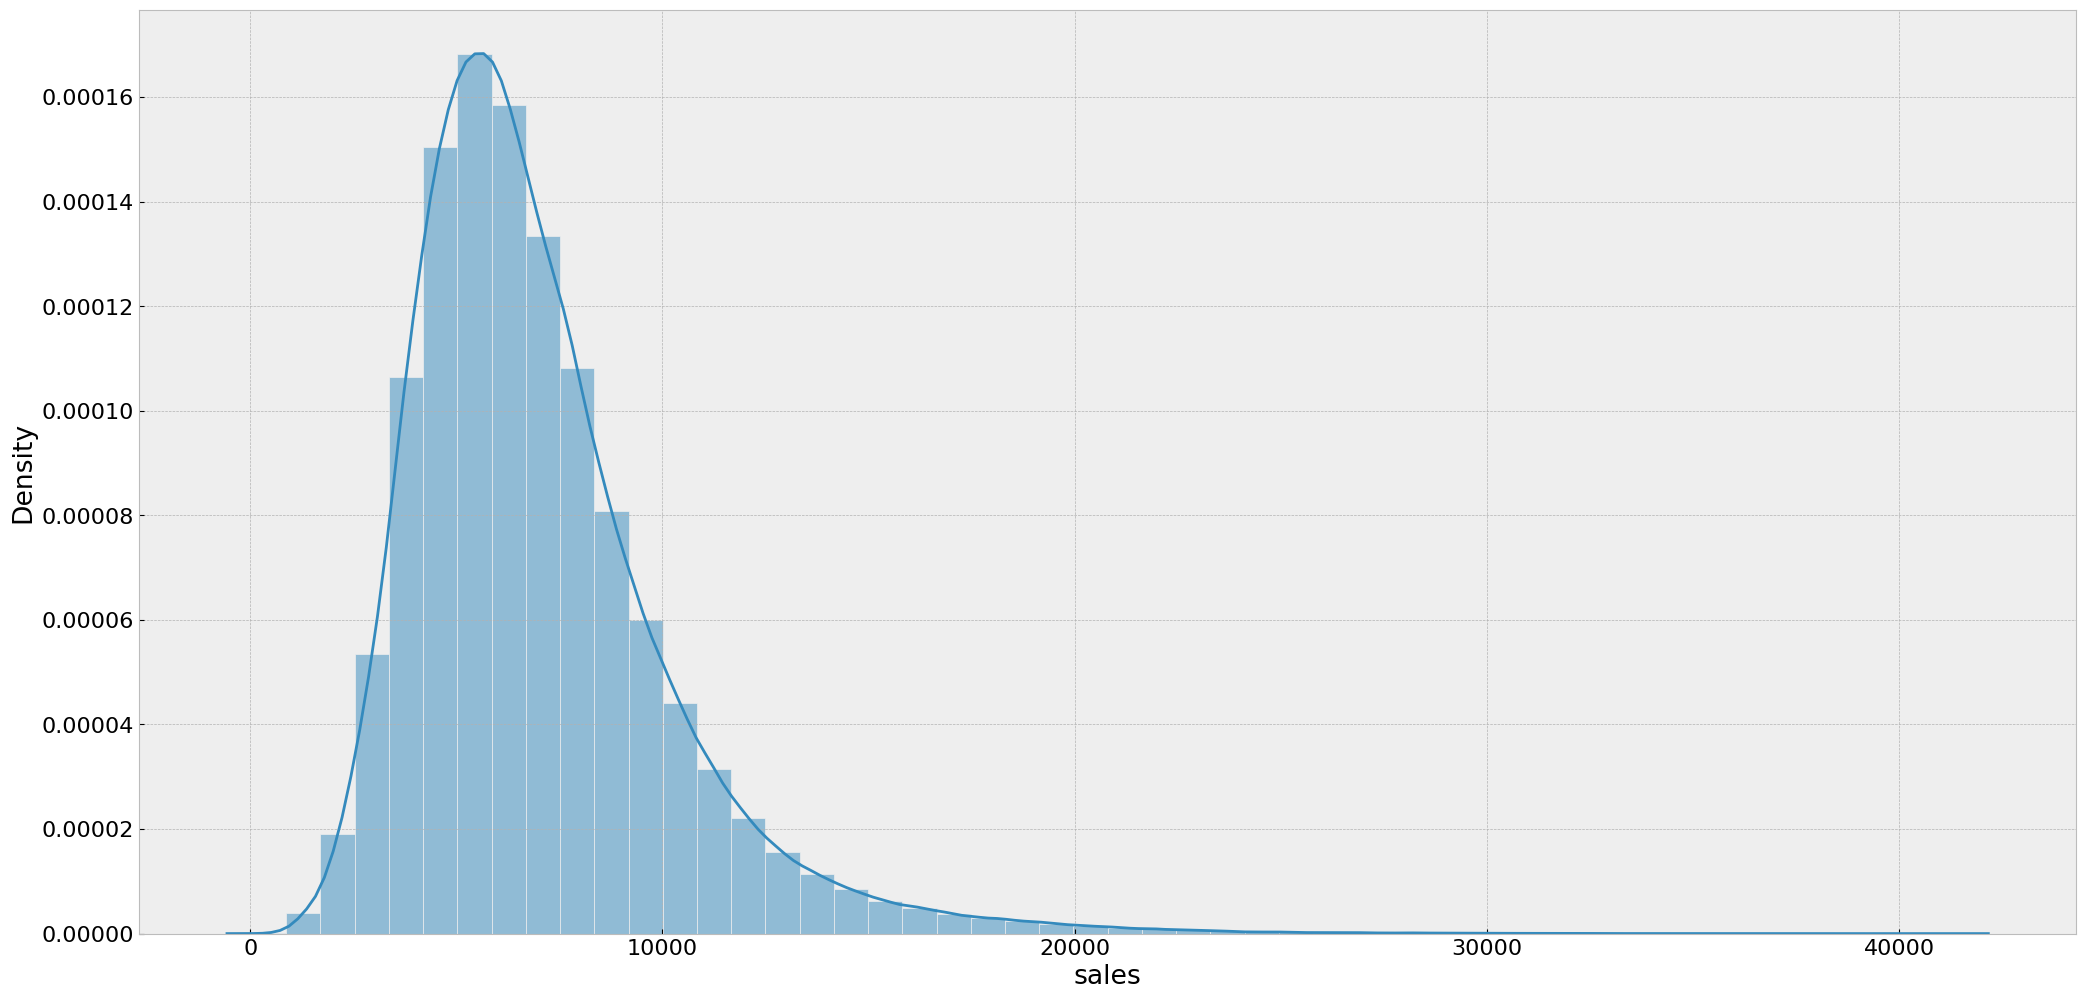

In [25]:
sns.histplot(df4['sales'], **histogram_args)

### 4.1.2 Numerical Variables Histogram (All Numerical features vs Response variable)

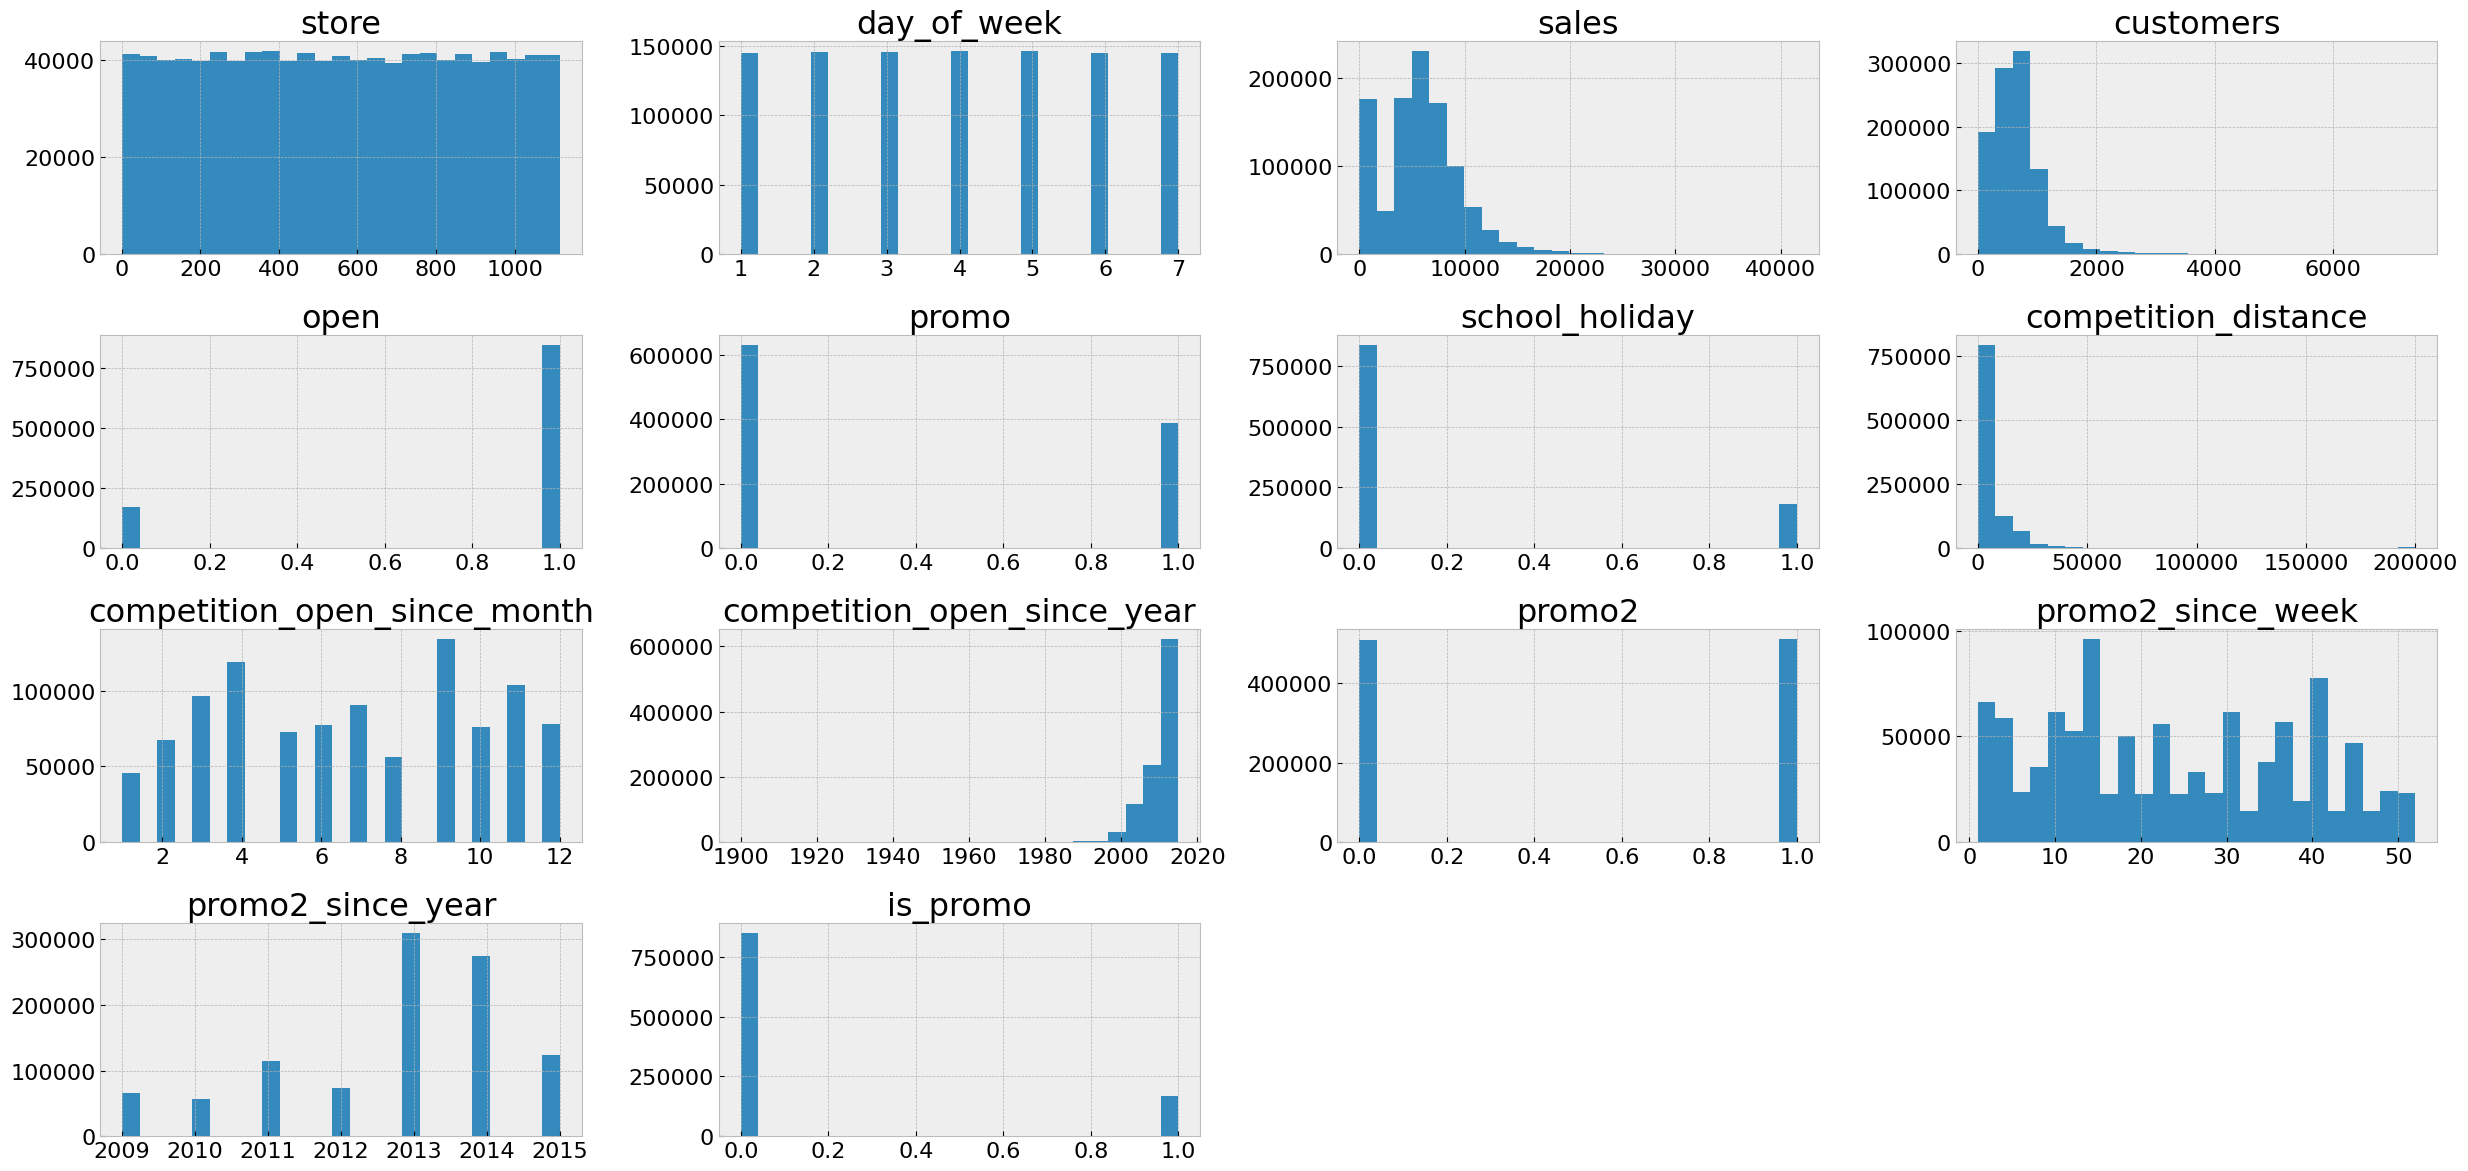

In [26]:
num_attributes.hist(bins=25);
plt.tight_layout()
plt.show()

### 4.1.3 Categorial Variables Histogram

In [27]:
df4['state_holiday'].unique()

array(['regular_day', 'public_holiday', 'easter_holiday', 'christmas'],
      dtype=object)

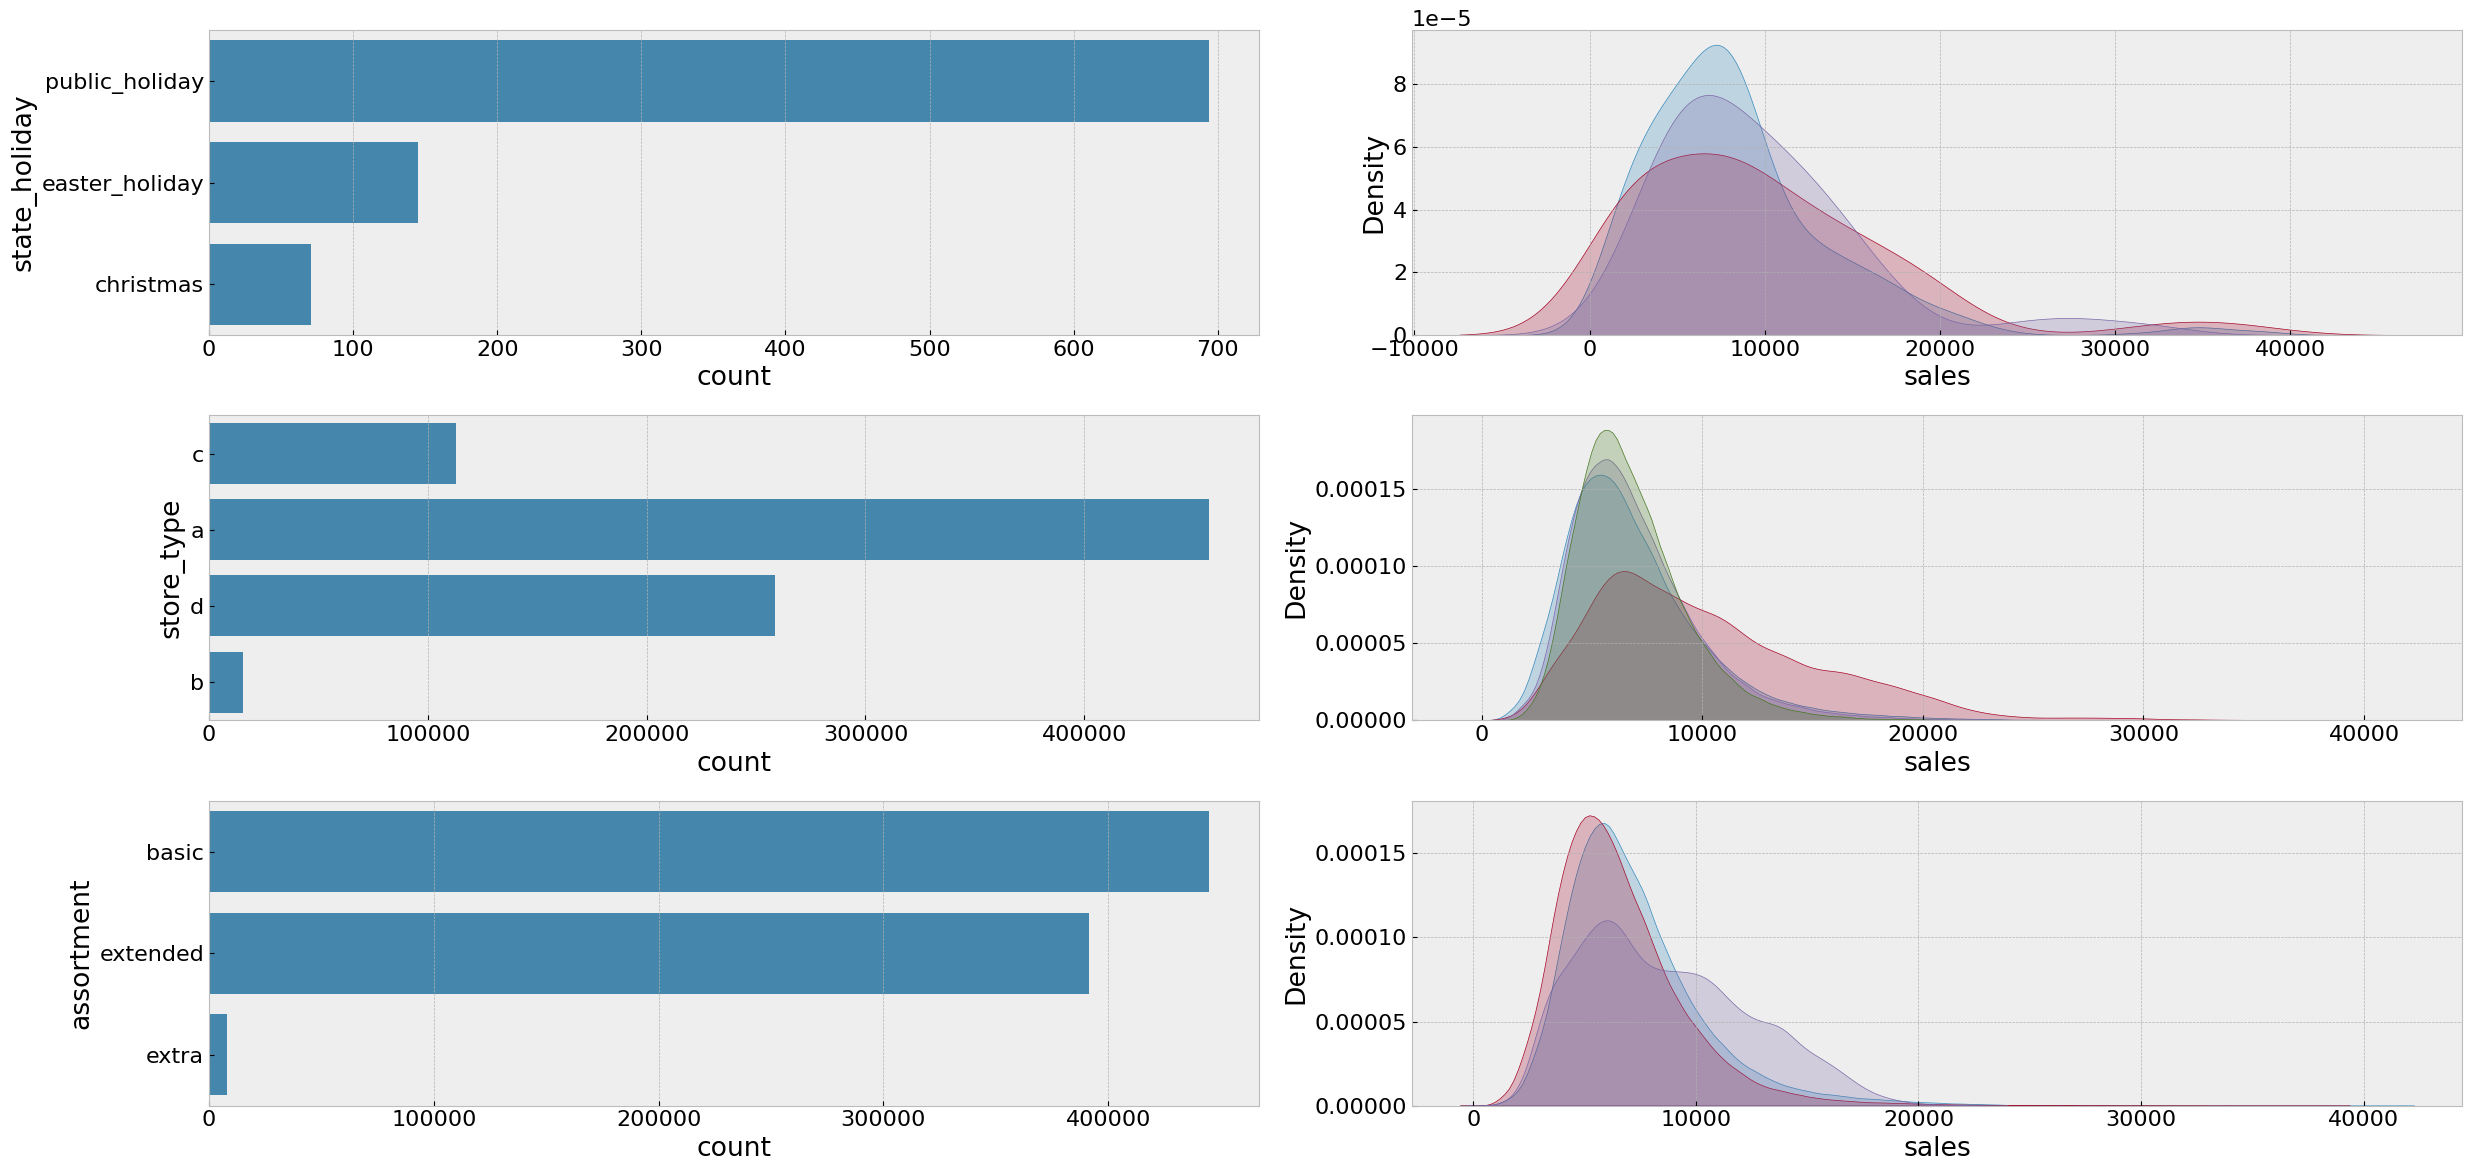

In [28]:
plt.subplot(3,2,1)
cutted = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(cutted['state_holiday'])

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', fill=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', fill=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', fill=True)

plt.subplot(3,2,3)
sns.countplot(df4['store_type'])

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', fill=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', fill=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', fill=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', fill=True)

plt.subplot(3,2,5)
sns.countplot(df4['assortment'])

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', fill=True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', fill=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', fill=True)

plt.tight_layout()


## 4.2. Bivariate Analysis (Hypothesis Validation)

#### **H1. Lojas com maior sortimentos deveriam vender mais.**

**FALSA** Lojas com MAIOR SORTIMENTO vendem MENOS.

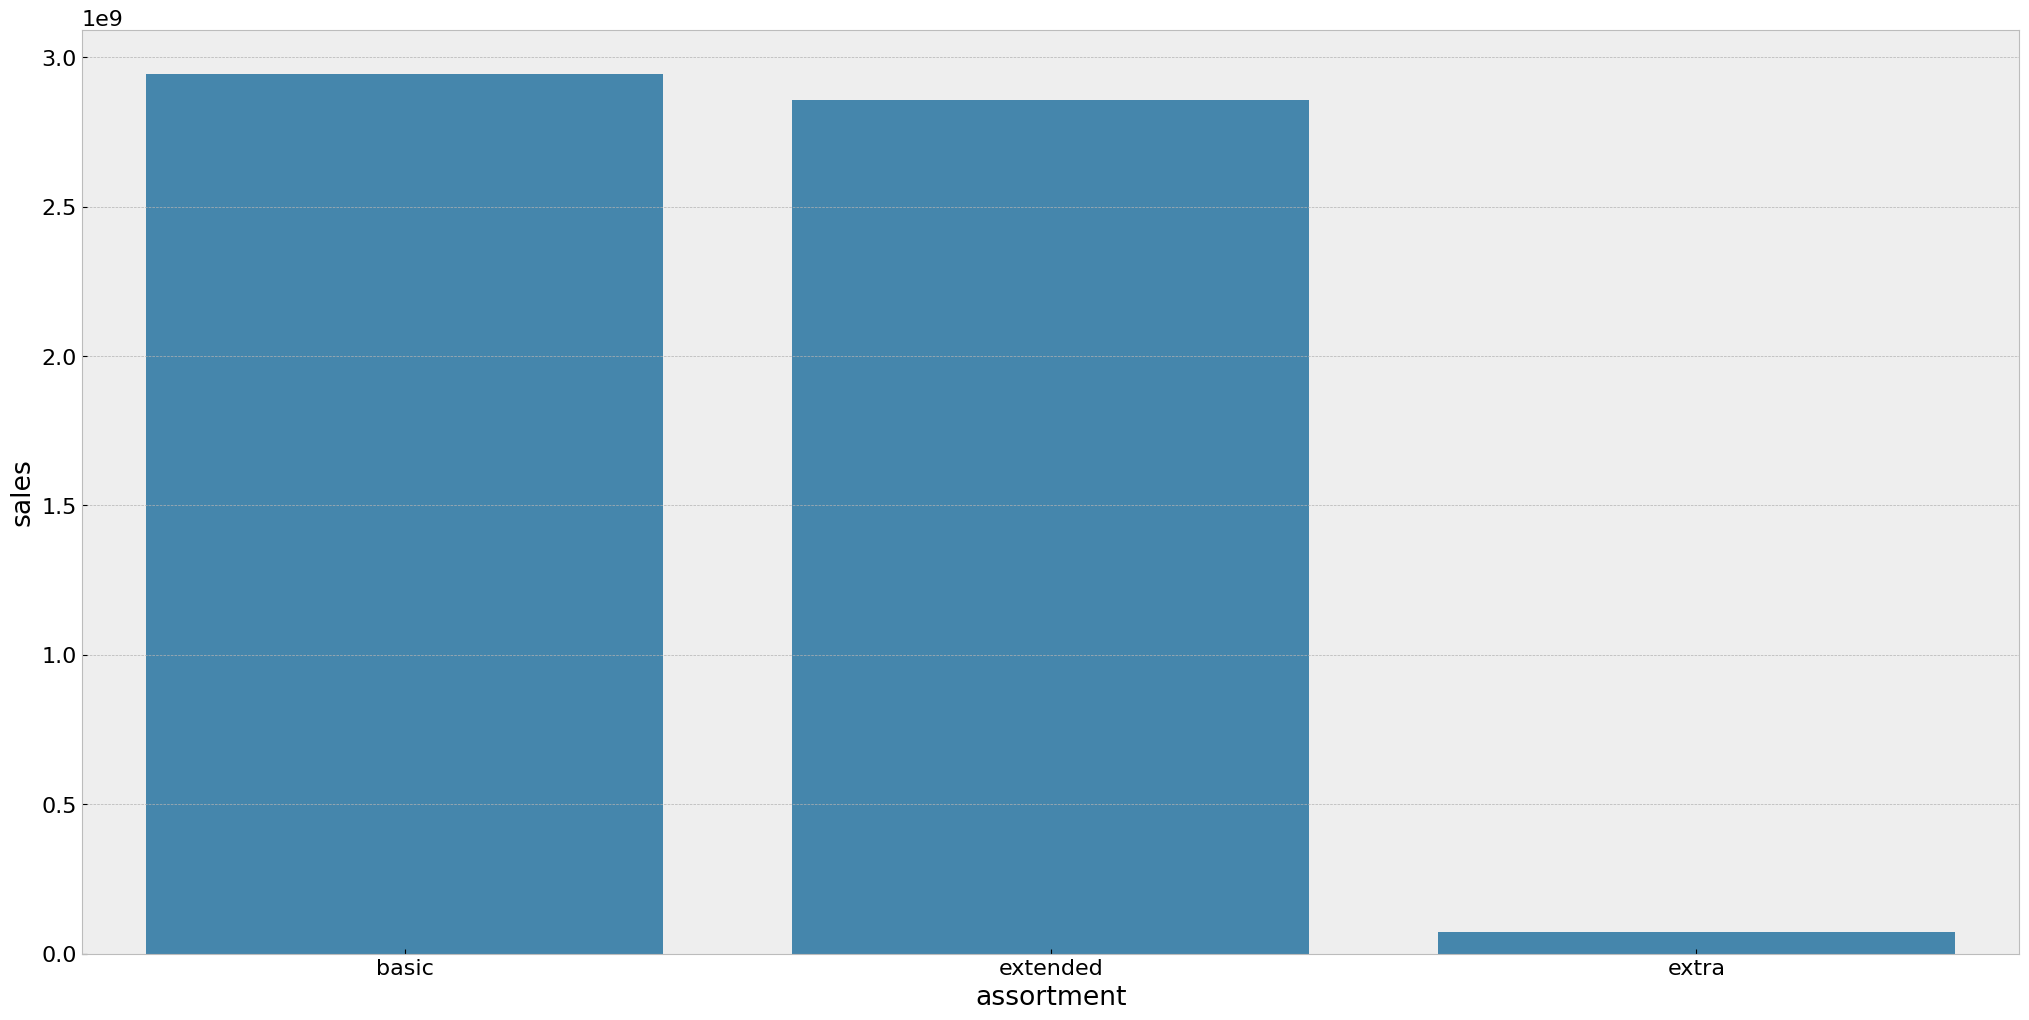

In [29]:
aux1 = df4[['assortment', 'sales']].groupby( 'assortment' ).sum().reset_index()
sns.barplot( x='assortment', y='sales', data=aux1 );

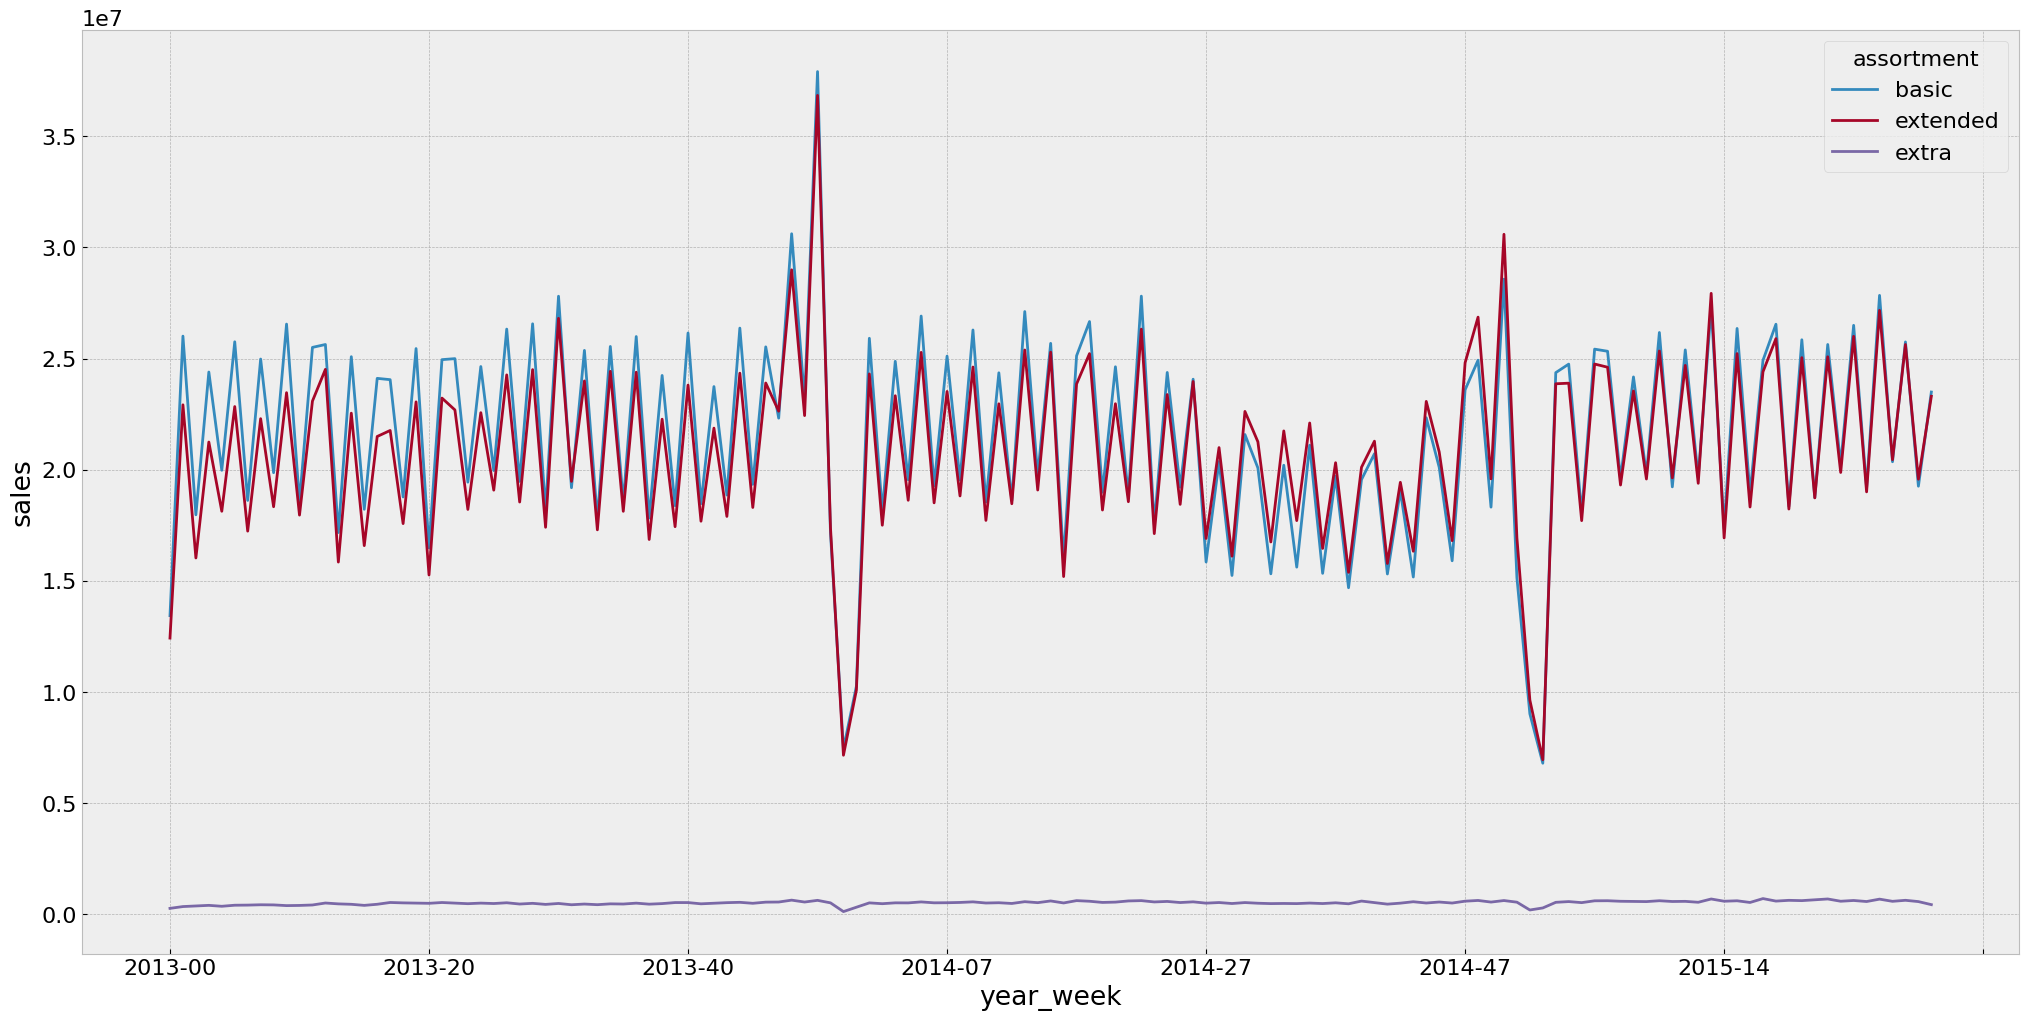

In [30]:
aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week','assortment'] ).sum().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales' ).plot();
plt.ylabel('sales');

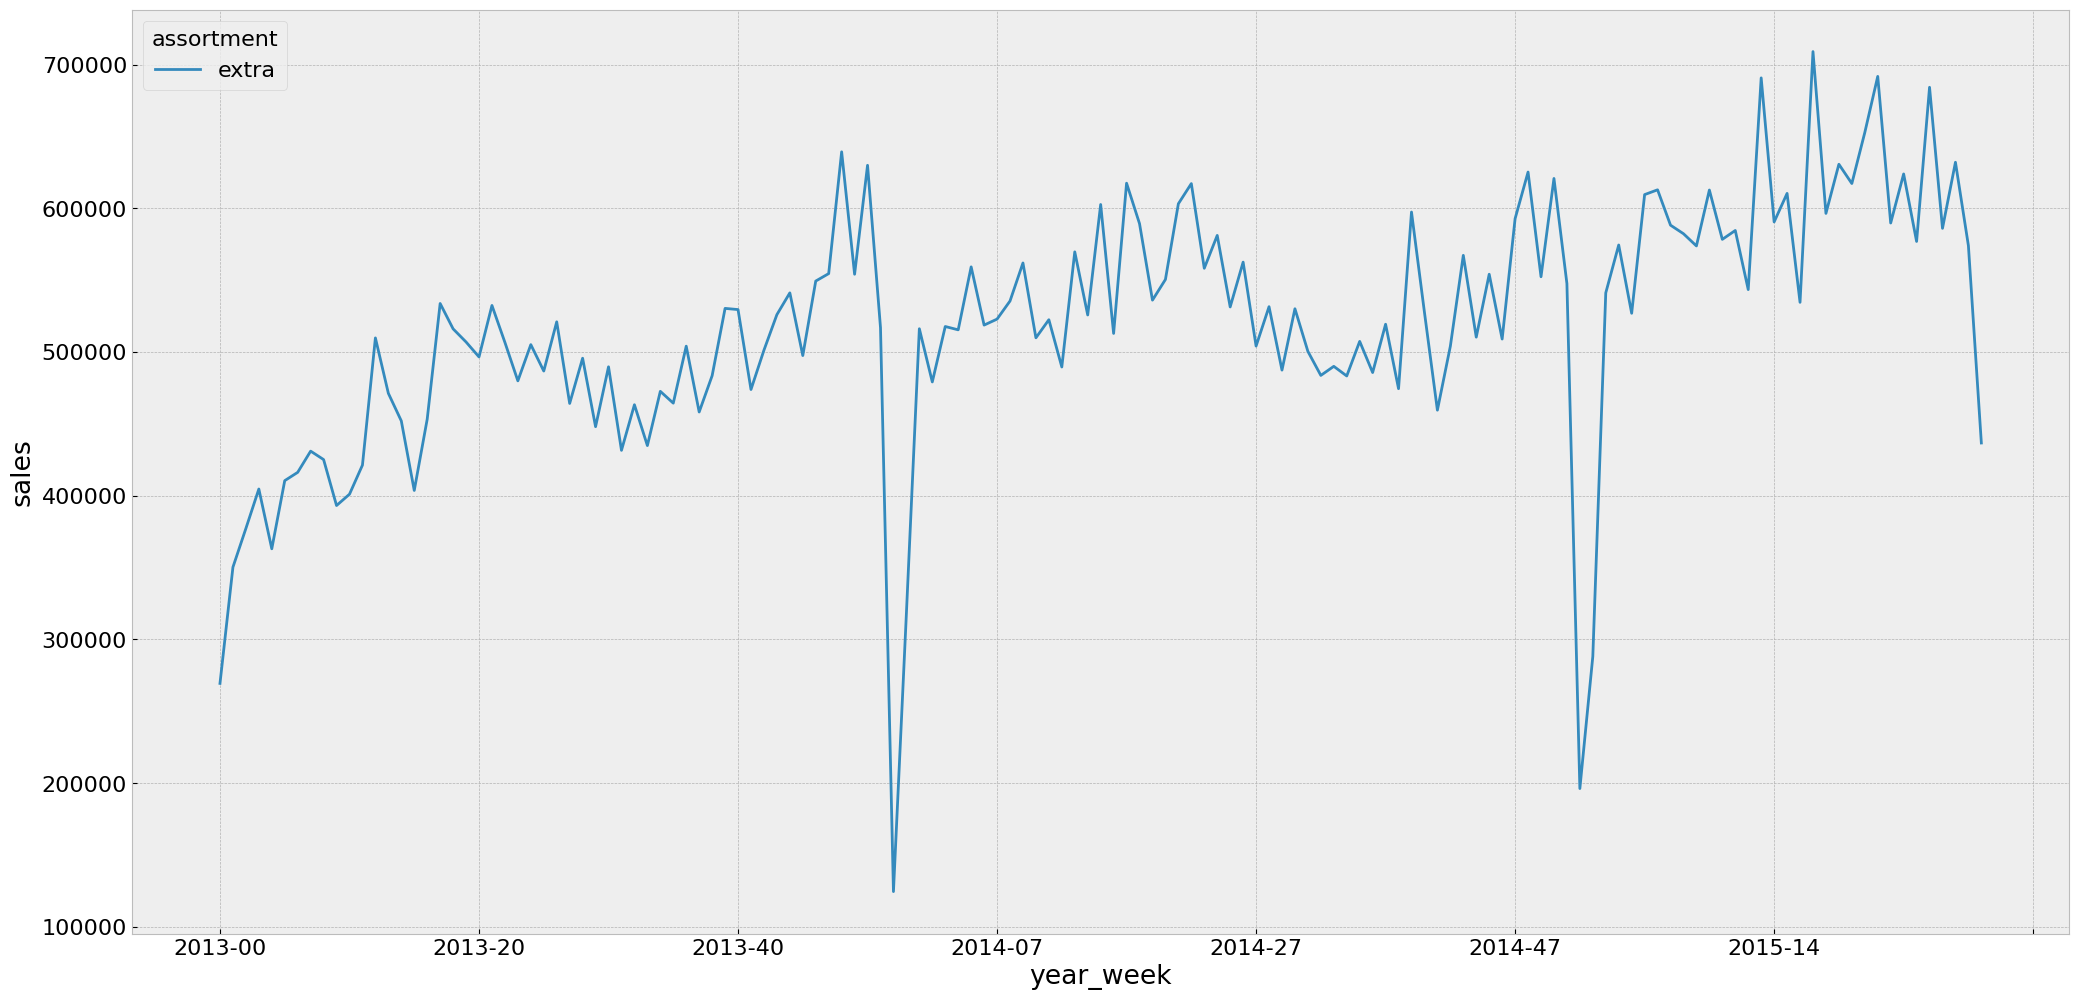

In [31]:
aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index='year_week', columns='assortment', values='sales' ).plot()
plt.ylabel('sales');

#### **H2. Lojas com competidores mais próximos deveriam vender menos.**

**FALSA** Lojas com COMPETIDORES MAIS PRÓXIMOS vendem MAIS.

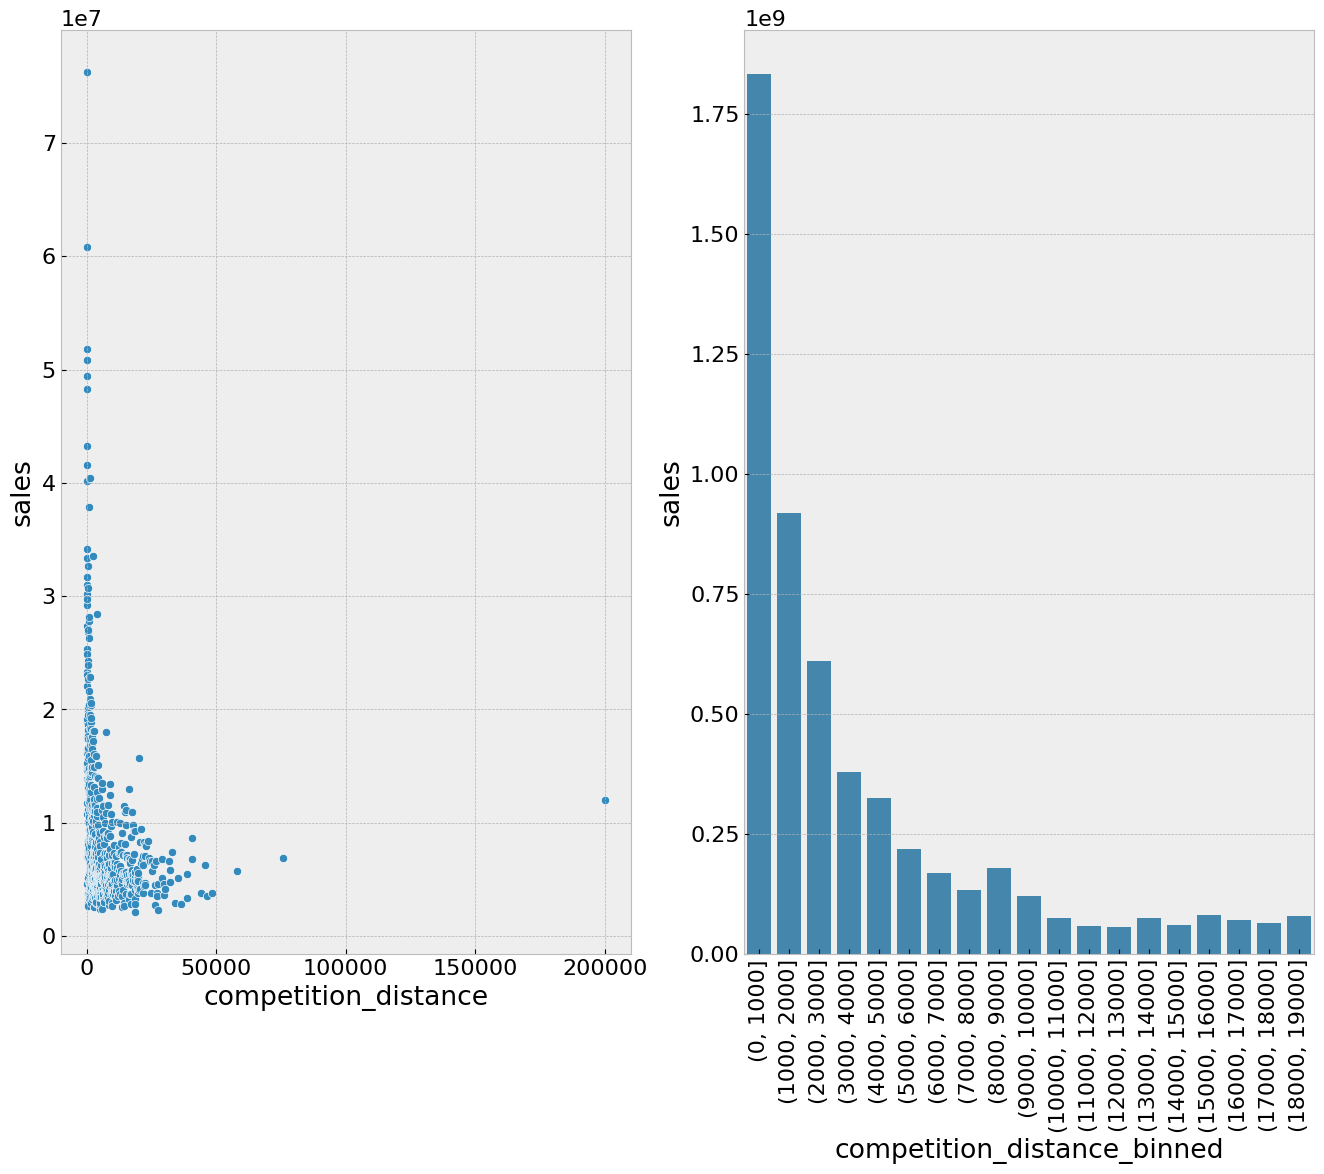

In [32]:
aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()
plt.subplot( 1, 3, 1 )
sns.scatterplot( x ='competition_distance', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
bins = list( np.arange( 0, 20000, 1000) )

aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins )
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned' ).sum().reset_index()

sns.barplot( x='competition_distance_binned', y='sales', data=aux2 );
plt.xticks( rotation=90 );

In [33]:
aux1[['competition_distance', 'sales']].corr(method='pearson').head()

,competition_distance,sales
competition_distance,1.000000,-0.229415
sales,-0.229415,1.000000


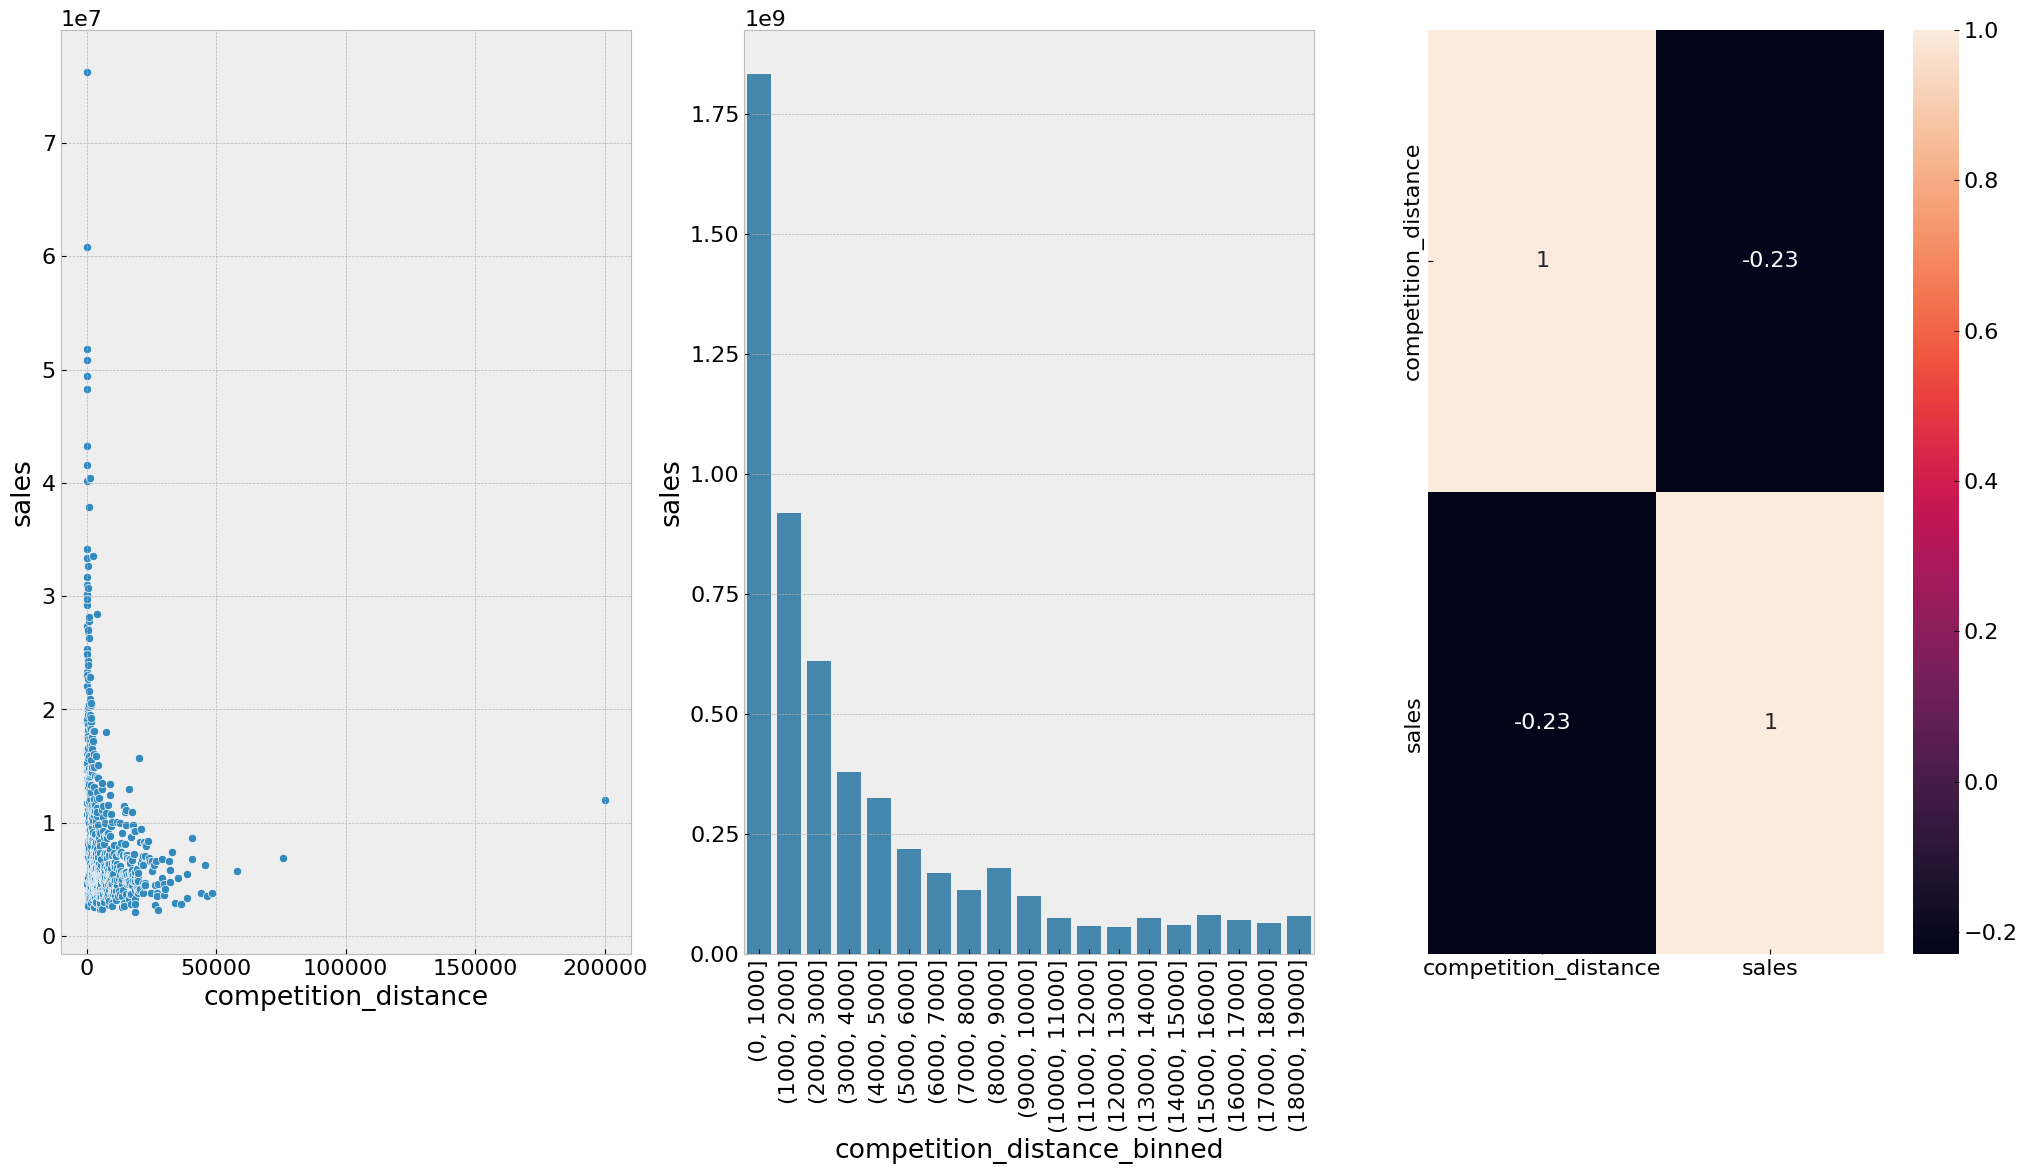

In [34]:
aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()
plt.subplot( 1, 3, 1 )
sns.scatterplot( x ='competition_distance', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
bins = list( np.arange( 0, 20000, 1000) )

aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins )
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned' ).sum().reset_index()

sns.barplot( x='competition_distance_binned', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 3 )
x = sns.heatmap(aux1[['competition_distance', 'sales']].corr( method='pearson' ), annot=True).grid(False);


#### **H3. Lojas com competidores à mais tempo deveriam vendem mais.**

**FALSA** Lojas com COMPETIDORES À MAIS TEMPO vendem MENOS

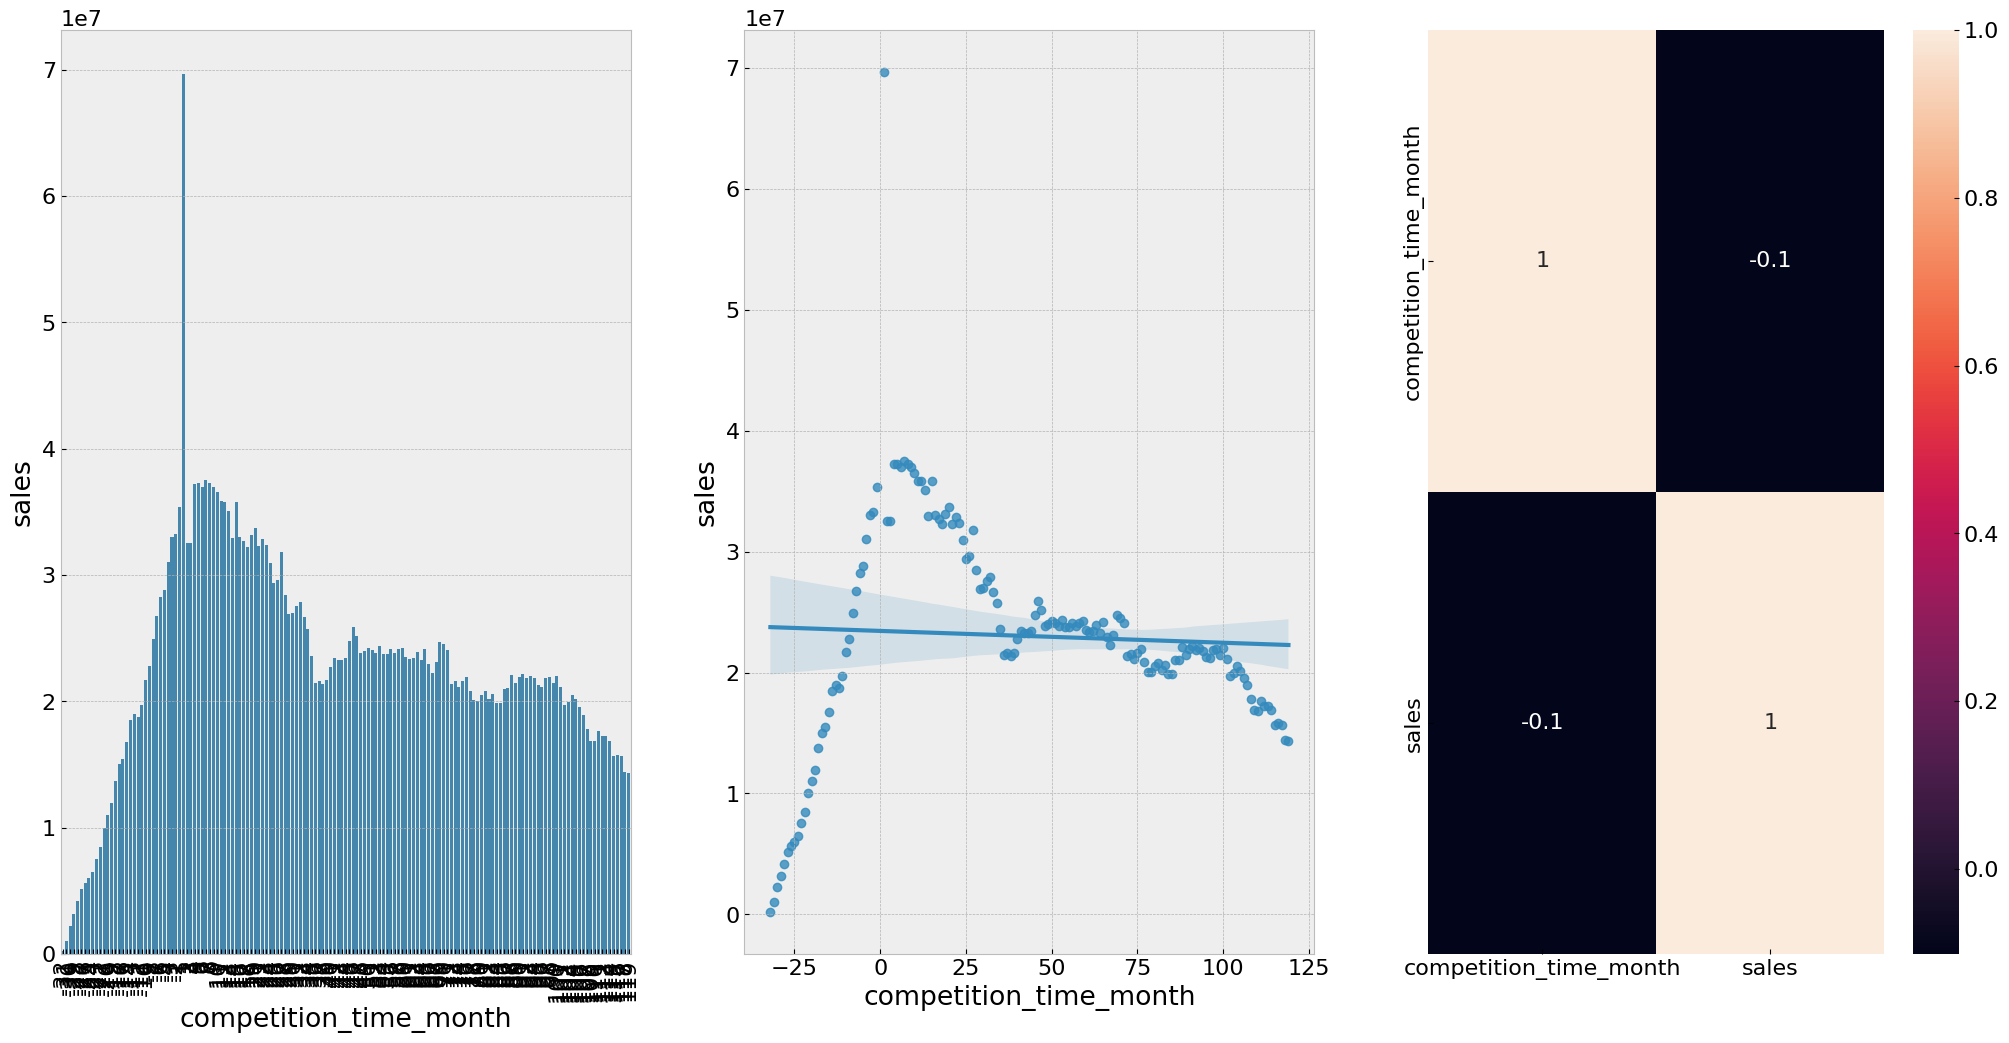

In [35]:
plt.subplot( 1, 3, 1 )
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month' ).sum().reset_index()
aux2 = aux1[( aux1['competition_time_month'] < 120 ) & (aux1['competition_time_month'] != 0 )]
sns.barplot( x='competition_time_month', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='competition_time_month', y='sales', data=aux2 );

plt.subplot( 1, 3, 3 )
x = sns.heatmap(aux1[['competition_time_month', 'sales']].corr( method='pearson'), annot=True ).grid(False);

#### **H4. Lojas com promoções ativas por mais tempo deveriam vender mais.**

FALSA Lojas com promocoes ativas por mais tempo vendem menos, depois de um certo periodo
de promocao

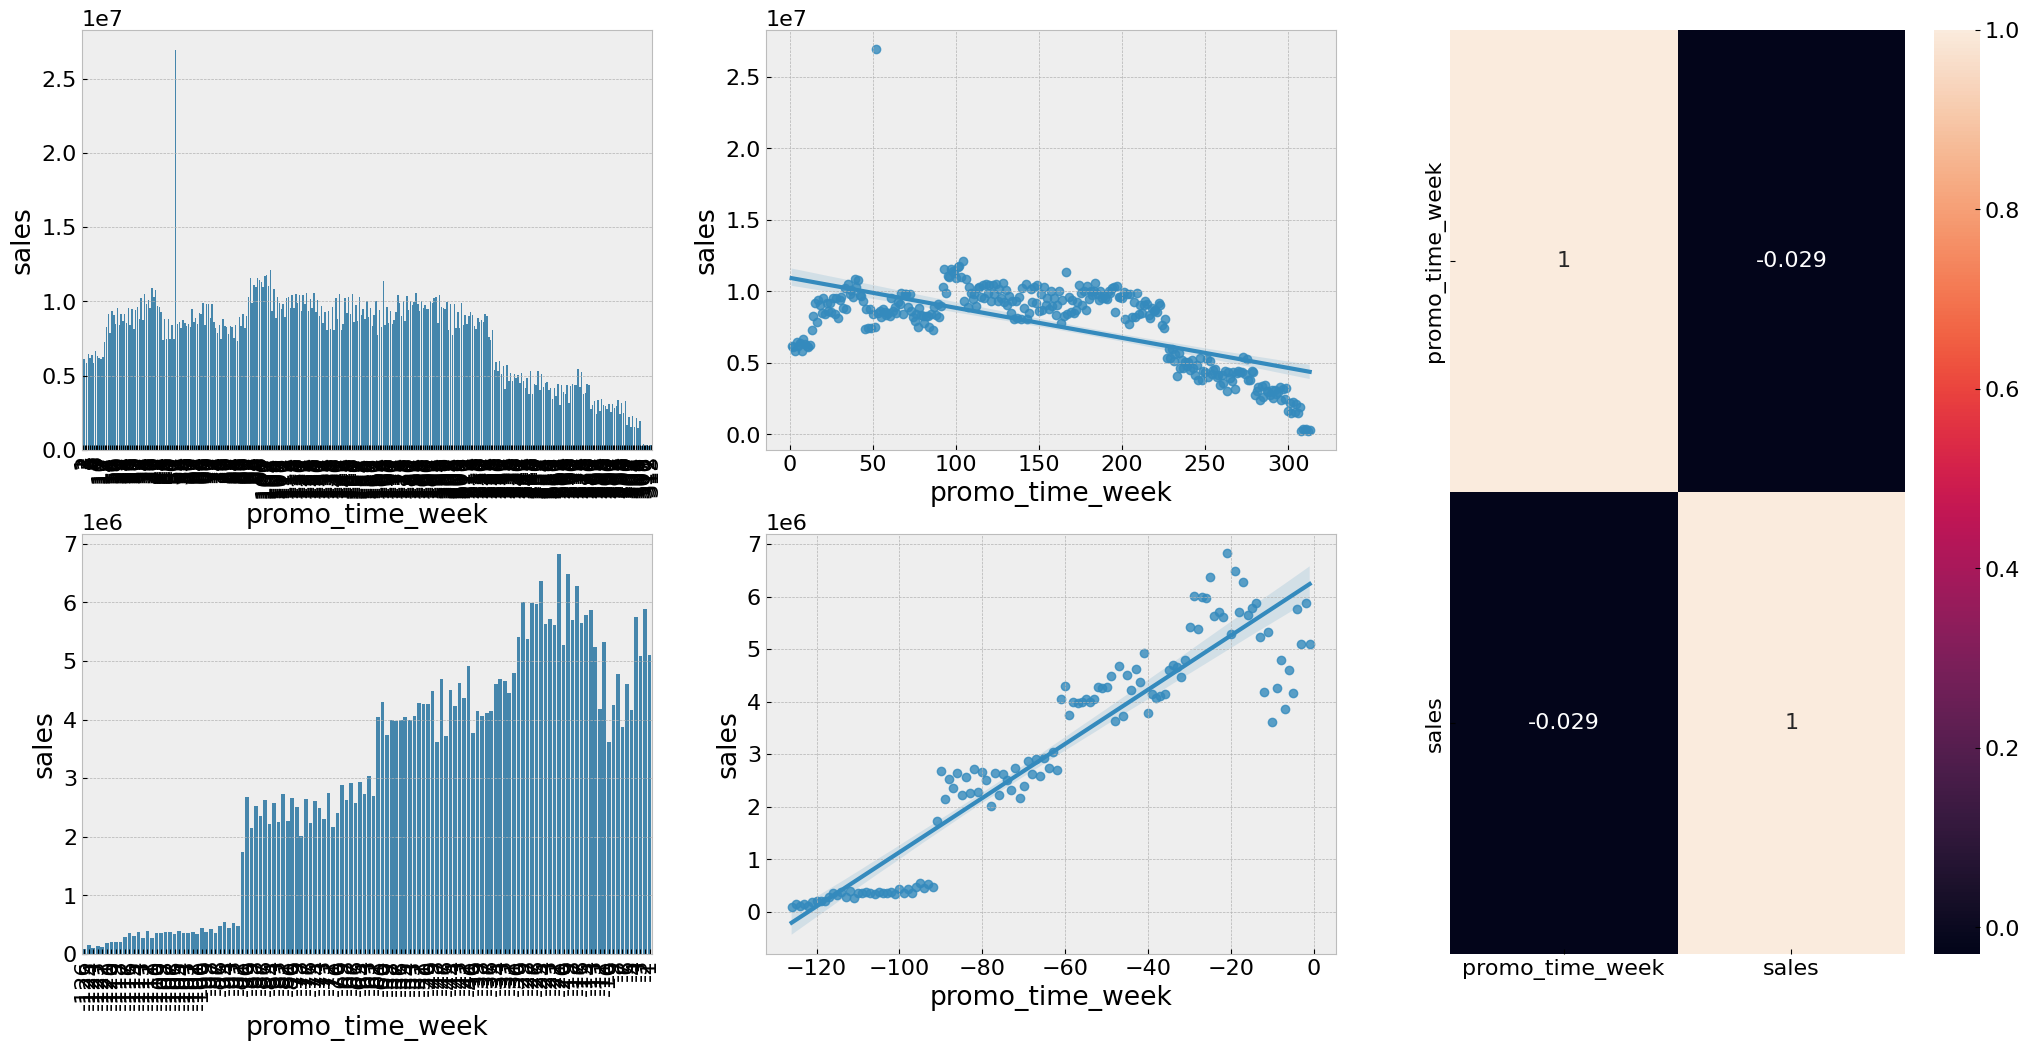

In [36]:
aux1 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week').sum().reset_index()

grid = plt.GridSpec( 2, 3 )

plt.subplot( grid[0,0] )
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendido
sns.barplot( x='promo_time_week', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( grid[0,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux2 );

plt.subplot( grid[1,0] )
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot( x='promo_time_week', y='sales', data=aux3 );
plt.xticks( rotation=90 );

plt.subplot( grid[1,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux3 );

plt.subplot( grid[:,2] )
sns.heatmap( aux1[['promo_time_week', 'sales']].corr( method='pearson' ), annot=True ).grid(False);

#### **H5. Lojas com mais dias de promoção deveriam vender mais.**

#### **H6. Lojas com mais promoções consecutivas deveriam vender mais.**

FALSA Lojas com mais promocoes consecutivas vendem menos

In [37]:
df4[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2'] ).sum().reset_index()


,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


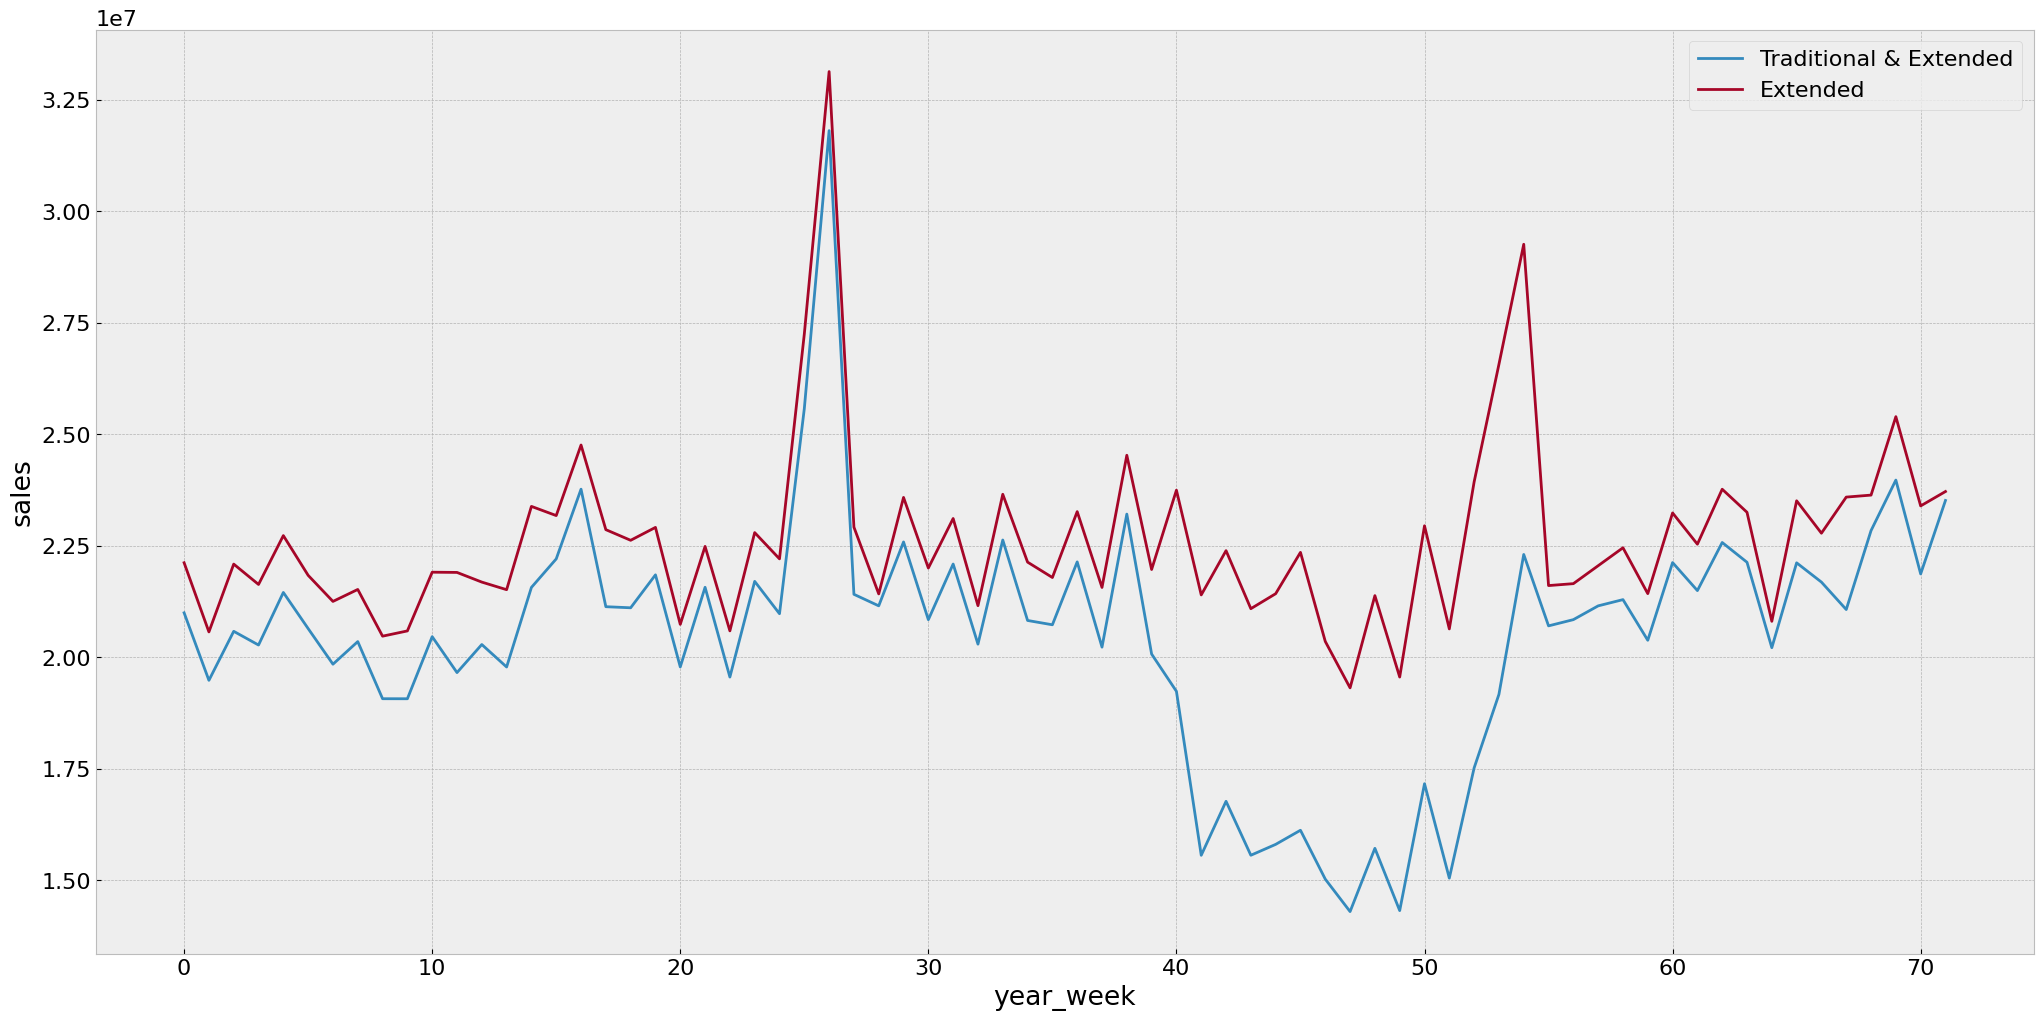

In [38]:
aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week','sales']].groupby( 'year_week' ).sum().reset_index()
ax = aux1.plot()
aux2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week','sales']].groupby( 'year_week' ).sum().reset_index()
aux2.plot( ax=ax )
ax.legend( labels=['Traditional & Extended', 'Extended']);
plt.xlabel('year_week');
plt.ylabel('sales');

#### **H7. Lojas abertas durante o feriado de Natal deveriam vender mais.**

FALSA Lojas abertas durante o feriado do Natal vendem menos

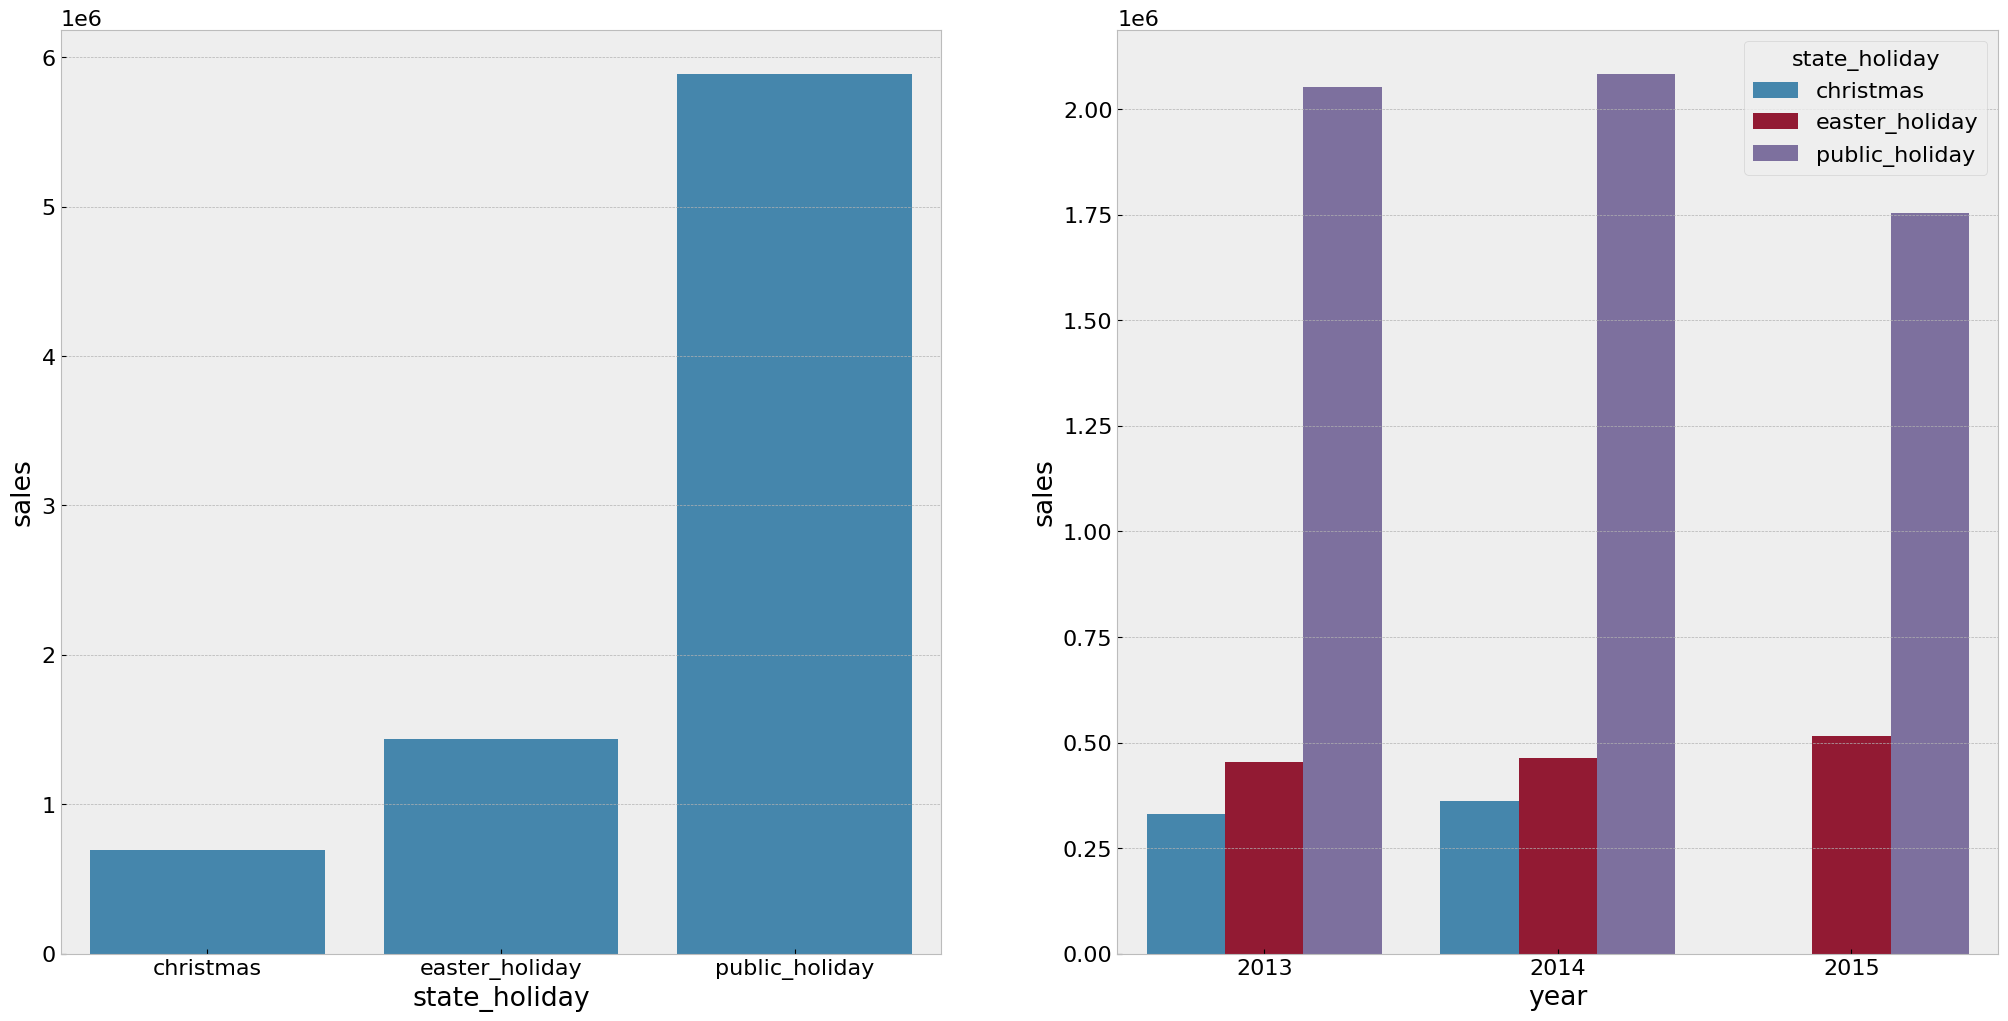

In [39]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot( 1, 2, 1 )
aux1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday' ).sum().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1 );

plt.subplot( 1, 2, 2 )
aux2 = aux[['year', 'state_holiday', 'sales']].groupby( ['year','state_holiday'] ).sum().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2 );

#### **H8. Lojas deveriam vender mais ao longo dos anos.**

FALSA Lojas vendem menos ao longo dos anos

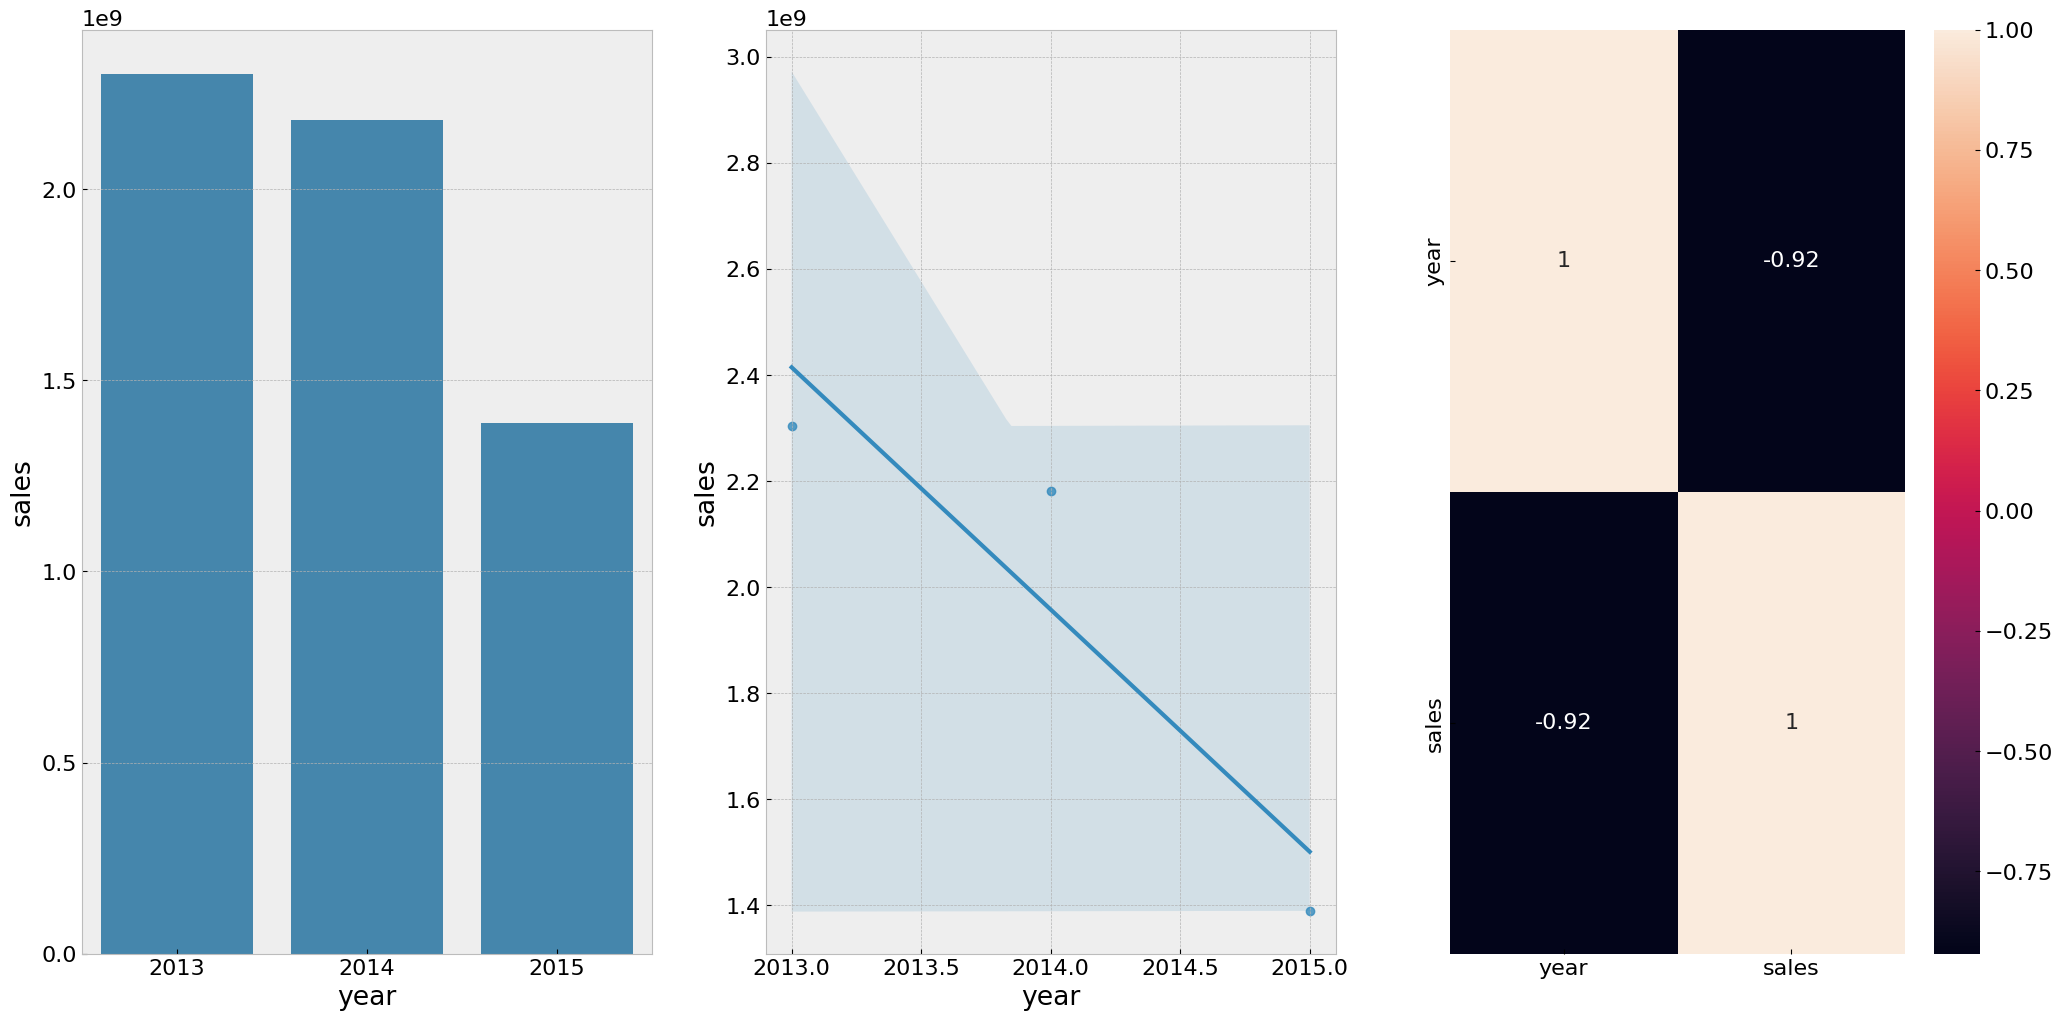

In [40]:
aux1 = df4[['year', 'sales']].groupby( 'year' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1[['year', 'sales']].corr( method='pearson' ), annot=True ).grid(False);

#### **H9. Lojas deveriam vender mais no segundo semestre do ano.**

FALSA Lojas vendem menos no segundo semestre do ano

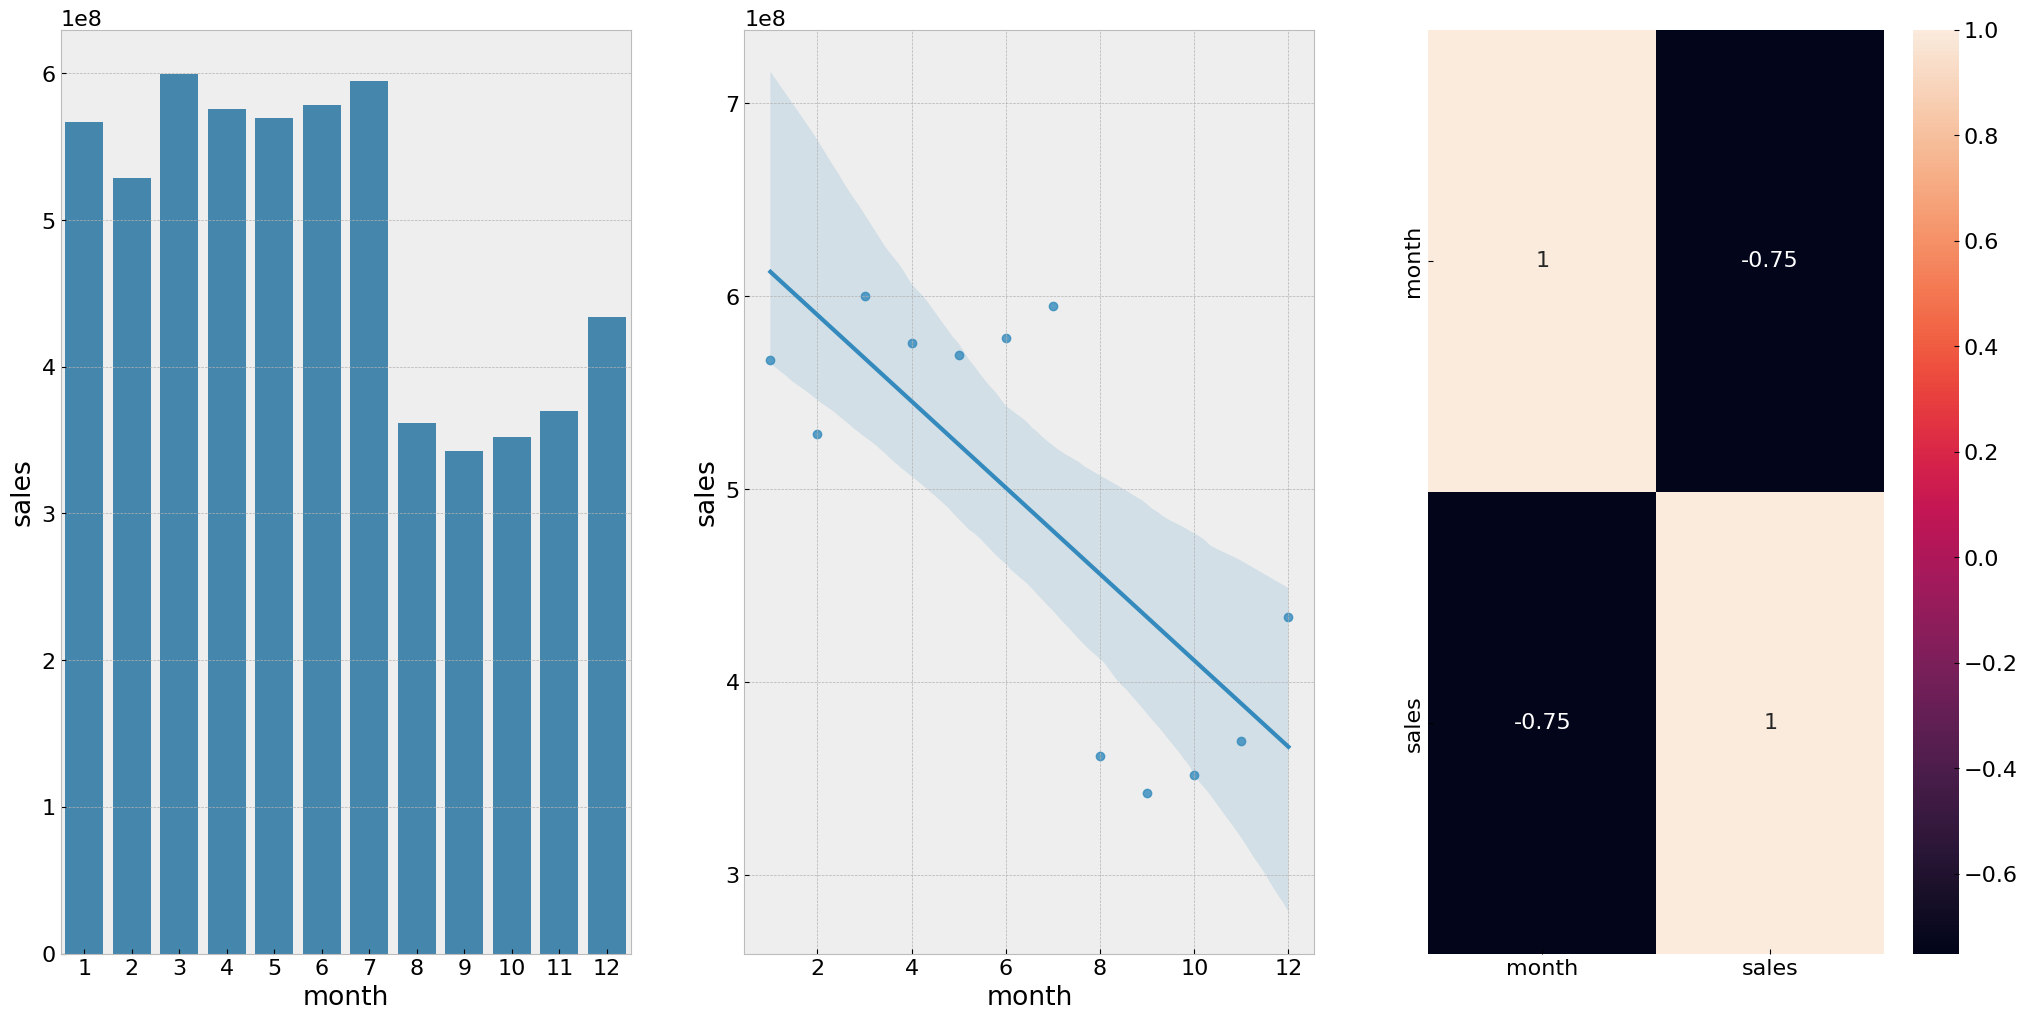

In [41]:
aux1 = df4[['month', 'sales']].groupby( 'month' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1[['month', 'sales']].corr( method='pearson' ), annot=True ).grid(False);

#### **H10. Lojas deveriam vender mais depois do dia 10 de cada mês.**

VERDADEIRA Lojas vendem mais depois do dia 10 de cada mes.

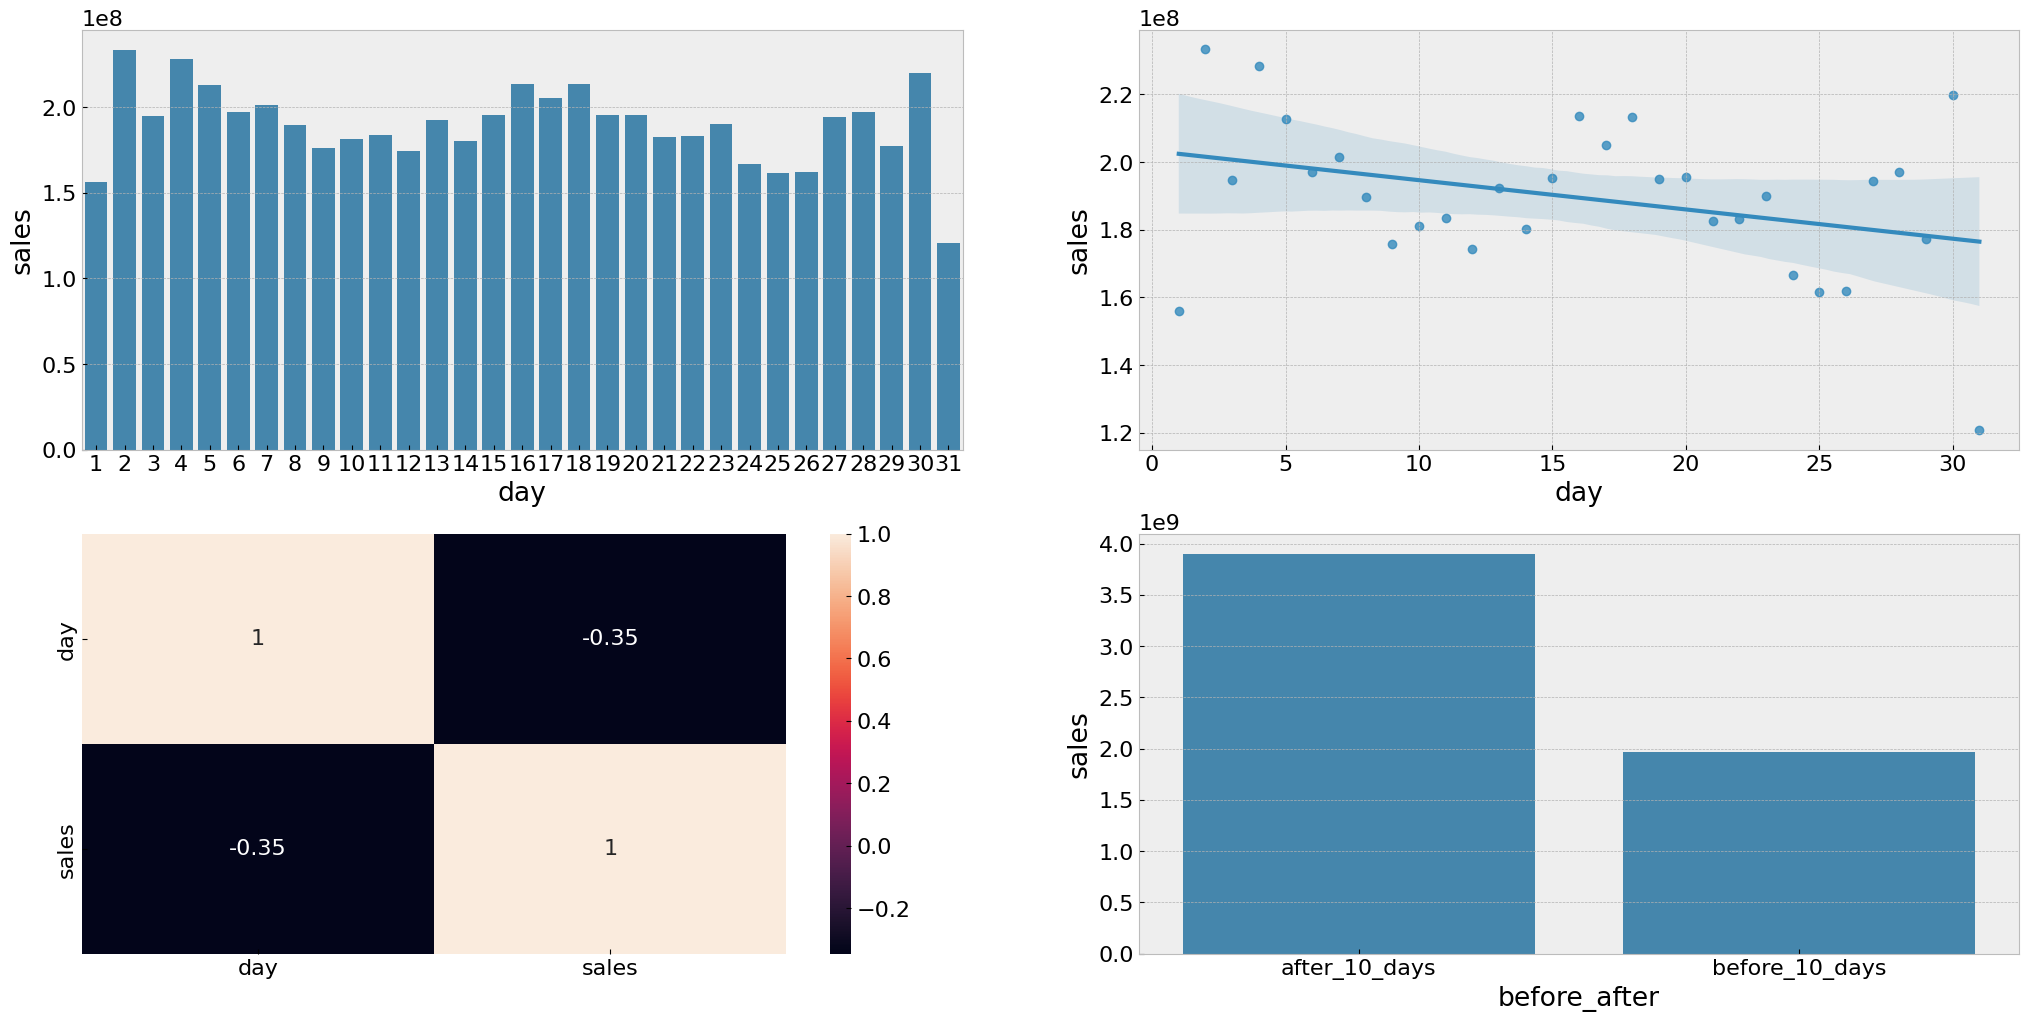

In [42]:
aux1 = df4[['day', 'sales']].groupby( 'day' ).sum().reset_index()

plt.subplot( 2, 2, 1 )
sns.barplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 2 )
sns.regplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 3 )
sns.heatmap( aux1[['day', 'sales']].corr( method='pearson' ), annot=True ).grid(False);

aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )
aux2 =aux1[['before_after', 'sales']].groupby( 'before_after' ).sum().reset_index()
plt.subplot( 2, 2, 4 )
sns.barplot( x='before_after', y='sales', data=aux2 );


#### **H11. Lojas deveriam vender menos aos finais de semana.**

VERDADEIRA Lojas vendem menos nos final de semana.

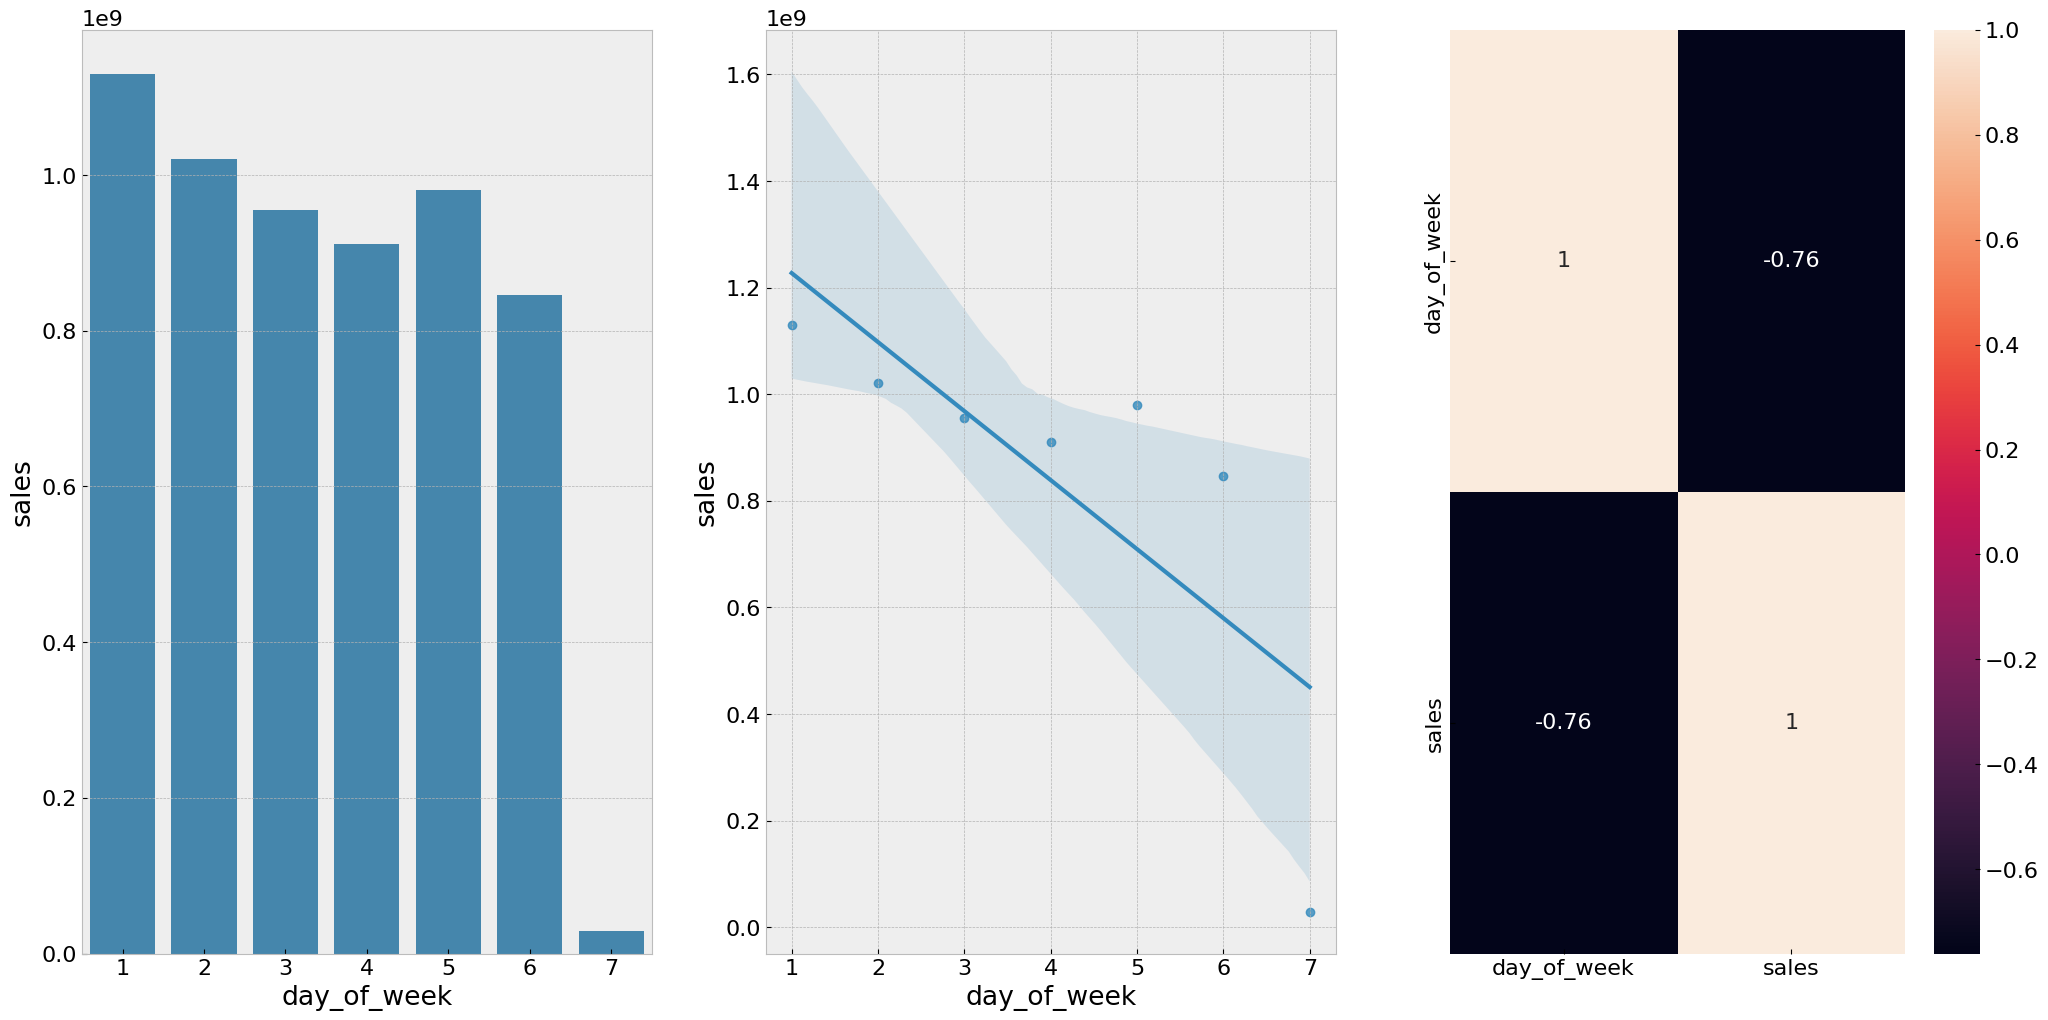

In [43]:
aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1[['day_of_week', 'sales']].corr( method='pearson' ), annot=True ).grid(False);

#### **H12. Lojas deveriam vender menos durante os feriados escolares.**

VERDADEIRA Lojas vendem menos durante os feriadso escolares, except os meses de Julho e Agosto. 

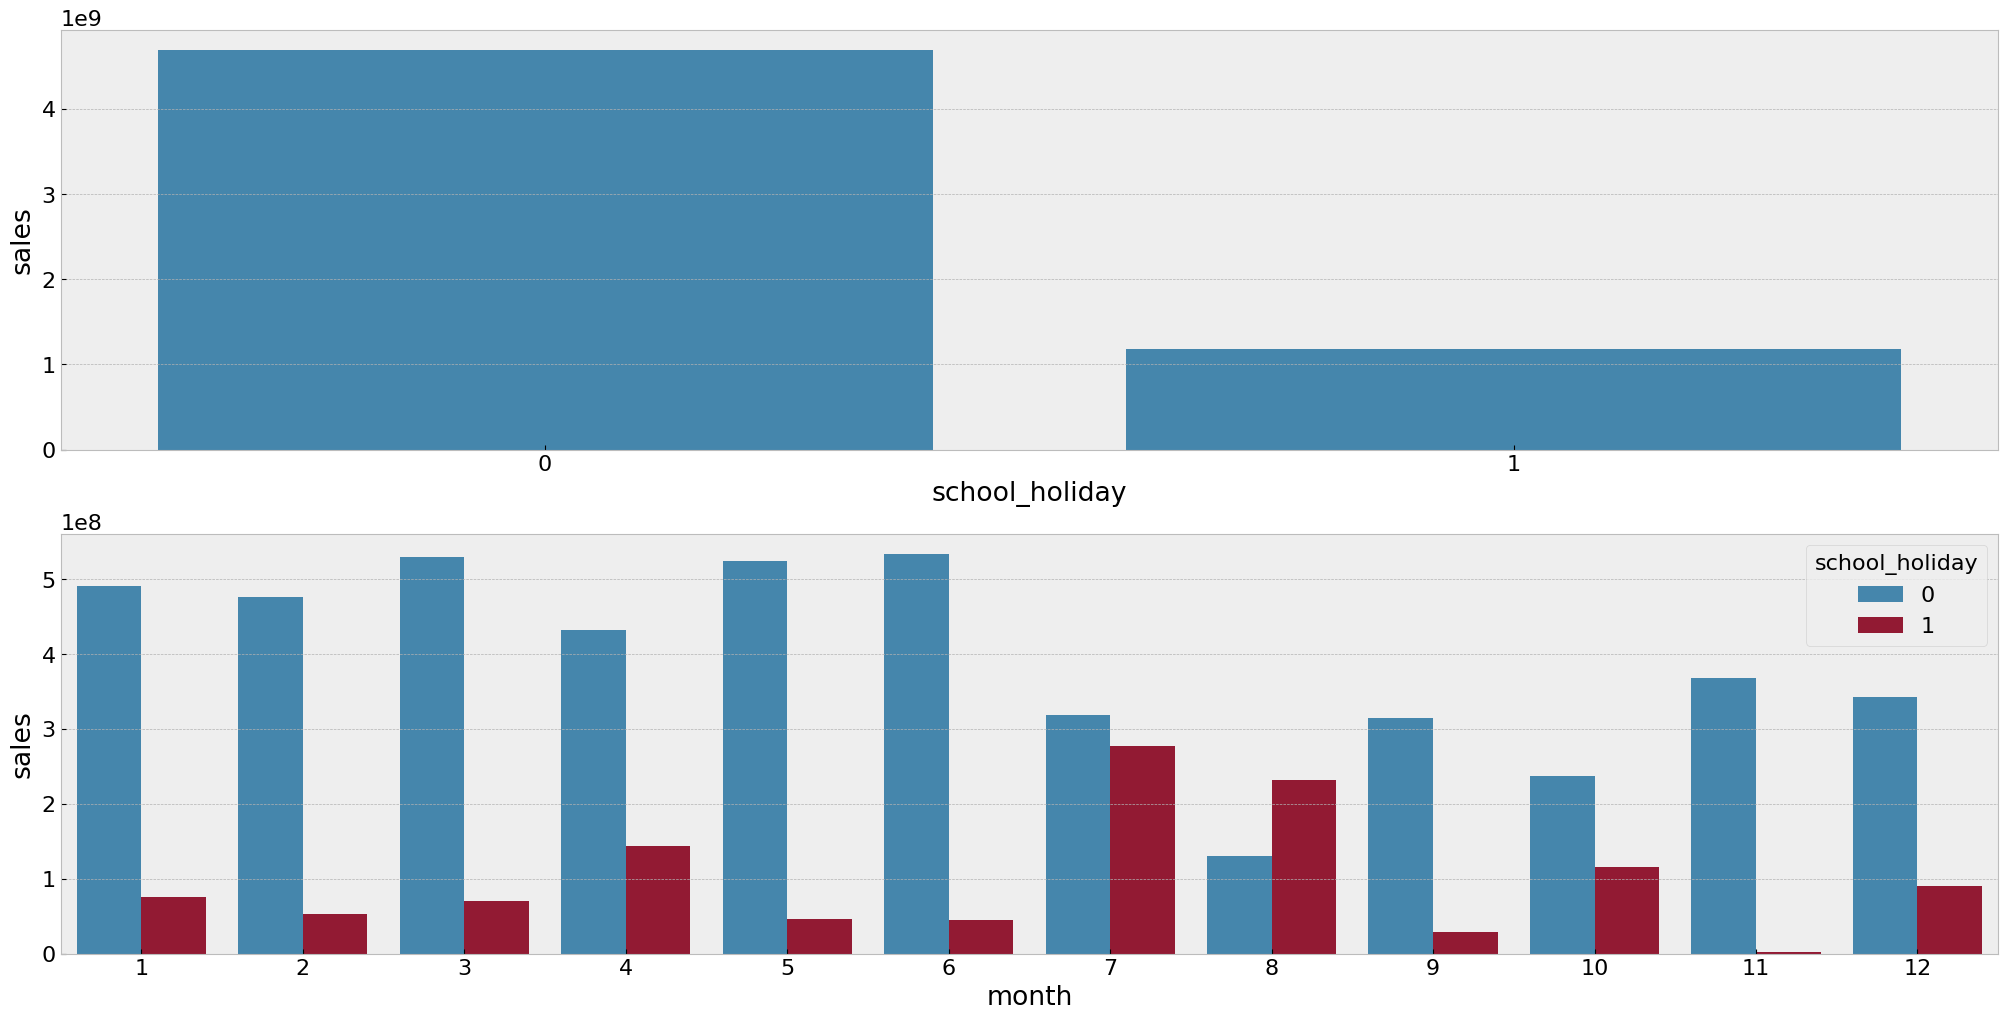

In [44]:
aux1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday' ).sum().reset_index()
plt.subplot( 2, 1, 1 )
sns.barplot( x='school_holiday', y='sales', data=aux1 );

aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month','school_holiday'] ).sum().reset_index()
plt.subplot( 2, 1, 2 )
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2 );


#### 4.3.1 Hypothesis validation summary 

In [45]:
tab = [['Hypothesis', 'Conclusion', 'Relevancy'],
    ['H1', 'Falsa', 'Baixa'],
    ['H2', 'Falsa', 'Media'],
    ['H3', 'Falsa', 'Media'],
    ['H4', 'Falsa', 'Baixa'],
    ['H5', '-', '-'],
    ['H7', 'Falsa', 'Baixa'],
    ['H8', 'Falsa', 'Media'],
    ['H9', 'Falsa', 'Alta'],
    ['H10', 'Falsa', 'Alta'],
    ['H11', 'Verdadeira', 'Alta'],
    ['H12', 'Verdadeira', 'Alta'],
    ['H13', 'Verdadeira', 'Baixa'],
]
print( tabulate( tab, headers='firstrow' ) )

Hypothesis    Conclusion    Relevancy
------------  ------------  -----------
H1            Falsa         Baixa
H2            Falsa         Media
H3            Falsa         Media
H4            Falsa         Baixa
H5            -             -
H7            Falsa         Baixa
H8            Falsa         Media
H9            Falsa         Alta
H10           Falsa         Alta
H11           Verdadeira    Alta
H12           Verdadeira    Alta
H13           Verdadeira    Baixa


## 4.3. Multivariate Analysis

### 4.3.1 Numerical columns

In [46]:
num_attributes.head()

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
0,1,5,5263,555,1,1,1,1270.0,9,2008,0,31,2015,0
1,2,5,6064,625,1,1,1,570.0,11,2007,1,13,2010,1
2,3,5,8314,821,1,1,1,14130.0,12,2006,1,14,2011,1
3,4,5,13995,1498,1,1,1,620.0,9,2009,0,31,2015,0
4,5,5,4822,559,1,1,1,29910.0,4,2015,0,31,2015,0


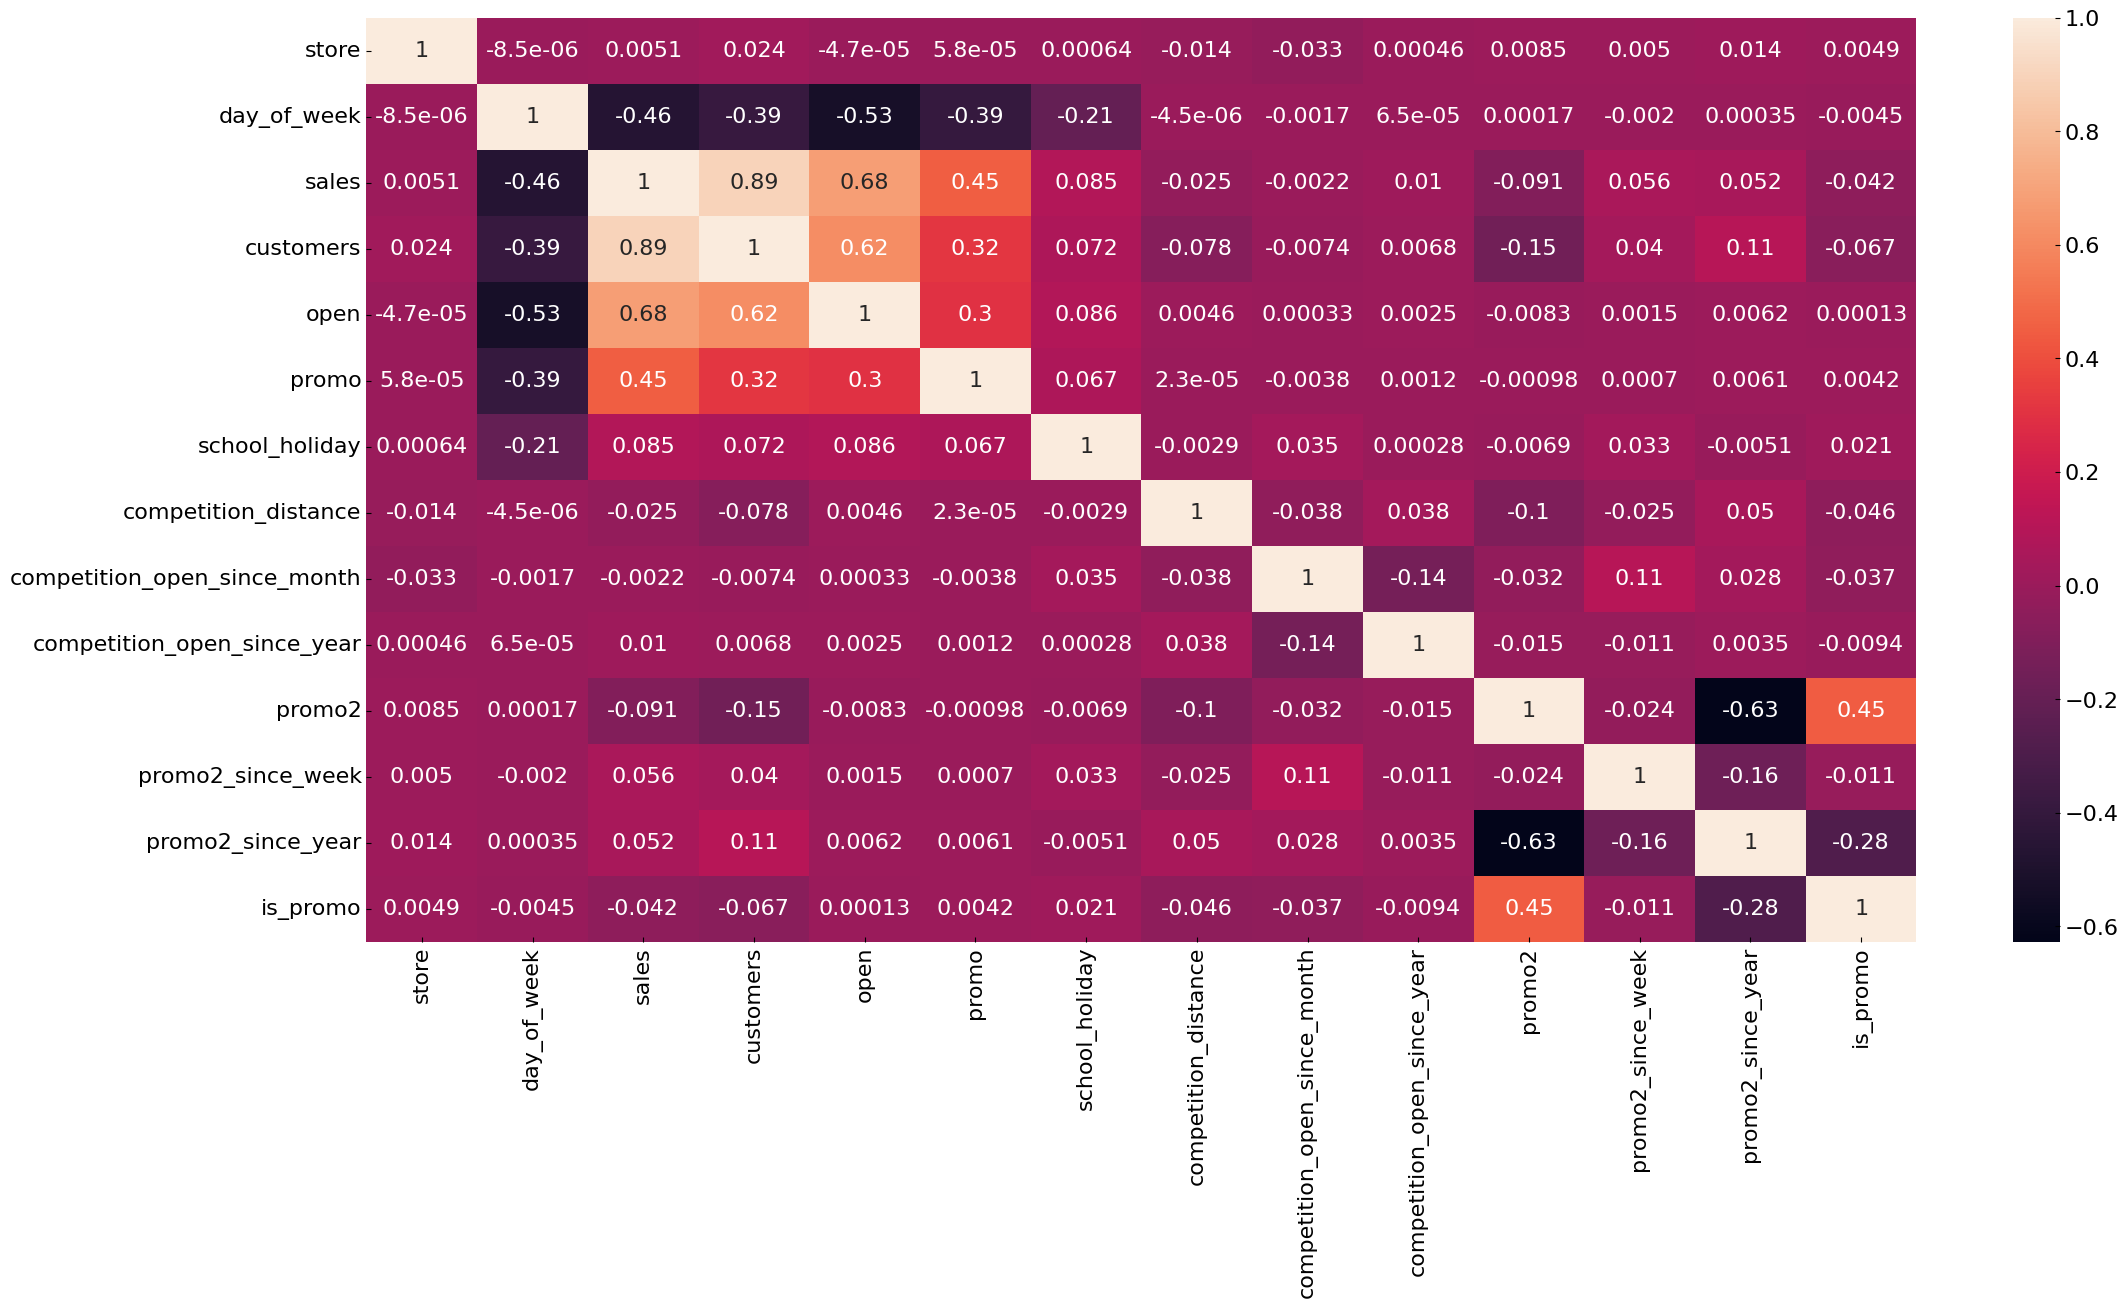

In [47]:
correlation = num_attributes.corr(method = 'pearson')
sns.heatmap(correlation, annot=True).grid(False);

### 4.3.2 Categorical columns

In [48]:
# Selecting only categorical columns
cat_features = df4.select_dtypes(include= 'object')

# Calculate cramer V for every combination of cat variables
a1 = cramerv(cat_features['state_holiday'], cat_features['state_holiday'])
a2 = cramerv(cat_features['state_holiday'], cat_features['store_type'])
a3 = cramerv(cat_features['state_holiday'], cat_features['assortment'])

a4 = cramerv(cat_features['store_type'], cat_features['state_holiday'])
a5 = cramerv(cat_features['store_type'], cat_features['store_type'])
a6 = cramerv(cat_features['store_type'], cat_features['assortment'])

a7 = cramerv(cat_features['assortment'], cat_features['state_holiday'])
a8 = cramerv(cat_features['assortment'], cat_features['store_type'])
a9 = cramerv(cat_features['assortment'], cat_features['assortment'])

# Final dataset
d = pd.DataFrame({
    'state_holiday': [a1, a2, a3],
    'store_type': [a4, a5, a6],
    'assortment': [a7, a8, a9]})

d = d.set_index(d.columns)


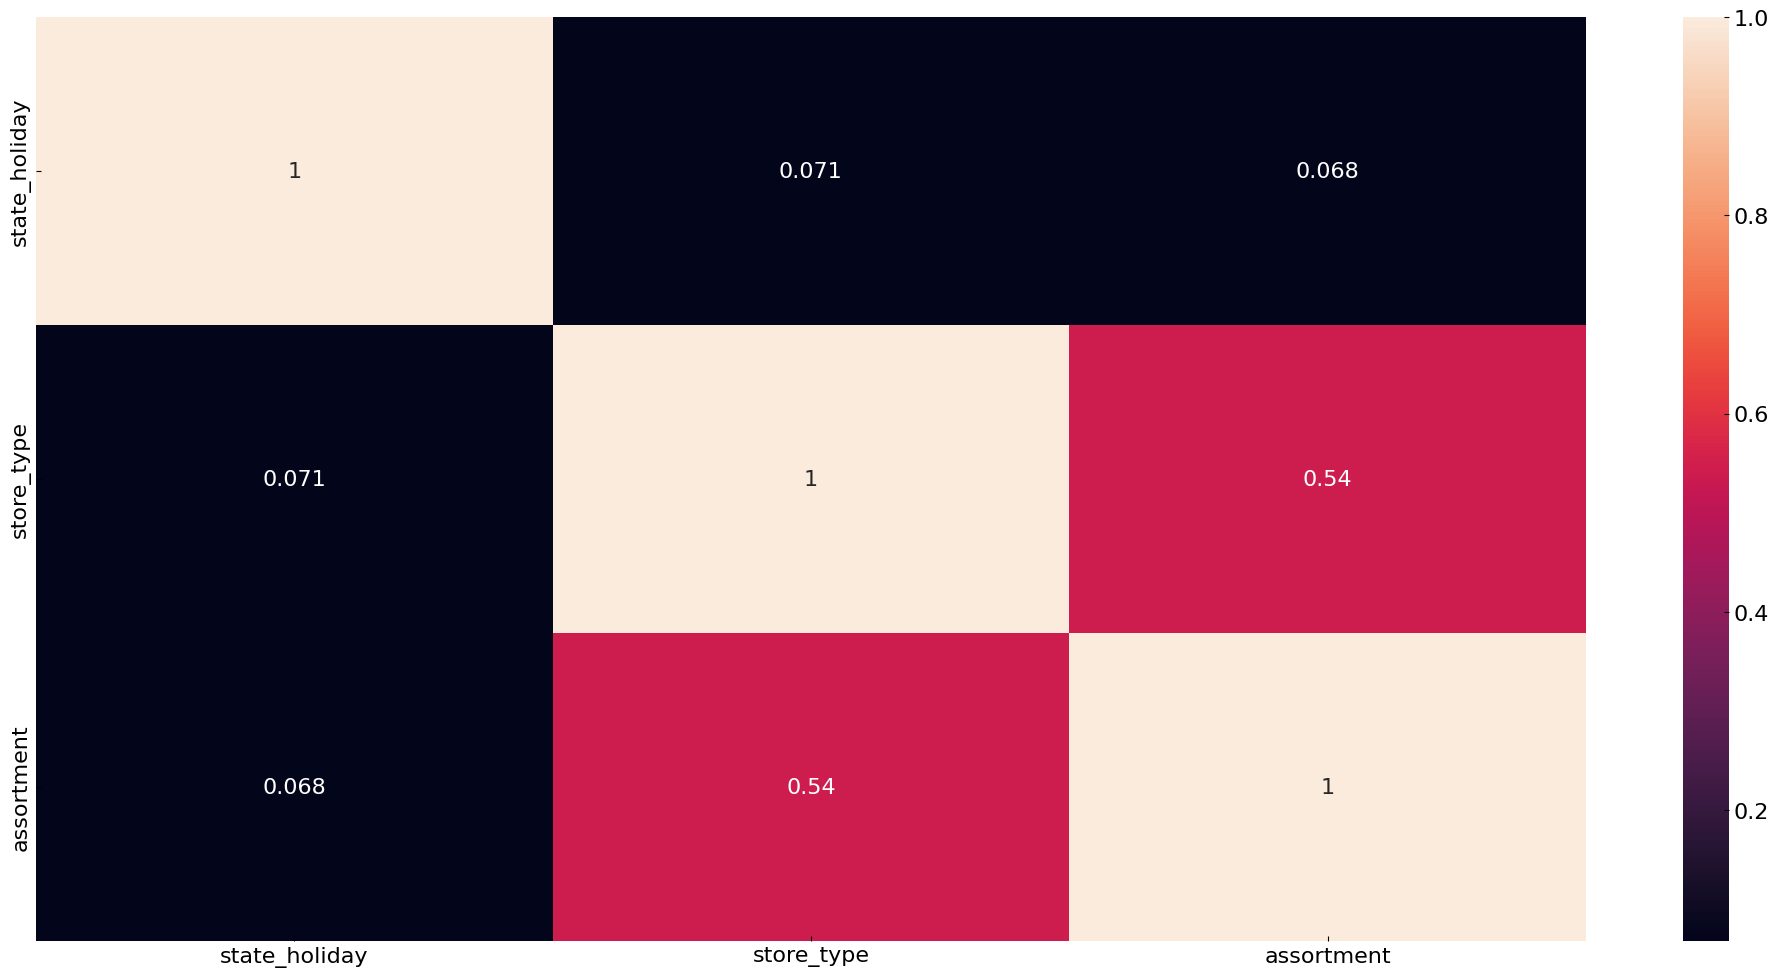

In [49]:
sns.heatmap(d, annot=True).grid(False);